In [40]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors
from qs_mps.applications.Z2.utils import get_cx, get_cy, find_closest_value, asymptotic_fit, plot_asymptotic_fit, weighted_average, arithmetic_average
from qs_mps.applications.Z2.relevant_observables import static_potential, static_potential_chis, static_potential_exact_L, static_potential_Ls, fit_luscher_term_g, fit_string_tension_g, fit_luscher, fit_string_tension, string_width_chis
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 20}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
# path = "pc"
cx = [3,37]
cy = [3,3]
# cx = None
# cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    path_tensor = f"C:/Users/HP/Desktop/projects/1_Z2"
    parent_path = path_tensor
    # parent_path = "G:/My Drive/projects/1_Z2"
    # path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get Luscher Term $\gamma$ and String Tension $\sigma$ from $V(g,R)$

- The luscher term exhibits universality in the roughening region. Hence, we can use it to detect the roughening point and the finite size effects on the theory of roughening and critical regions
- The same can be said about the string tension. It is a natural order parameter and depicted in the work of Creutz. It goes to zero in the decoupling phase where the string ceases to exist and it grows in the confining phase where the two charges are rigidly bonded. In addition, it can be used along with the string width to quantify the spreading of the energy density in the roughening phase. In this critical region, it is supposed to still be finite, while the string width diverges for the fluctuations. We can also use these two quantities to better characterize the roughening phase and possible effects due to finite size and boundary conditions.

There are different ways to get these quantities:  
- Luscher:  
    1. second discrete derivative of the potential  
    2. fit of the correction $1/R$ to the linear term in the potential  
- string tension:
    1. Wilson loop expectation values on the lattice, enclosing the string
    2. fit of the slope of the linear term in the potential
- string thickness:
    1. a sum weighted by the distance to the axis of the string of the plaquette electric energy density difference between the two-charge and vacuum sector
    2. analytical solution to assess the validity of the point 1. It is a formula showing the logarithmic behavior in R and weighted by the inverse of the string tension $1/(2\pi\sigma)log(R/R_{UV})$ 

### Get the potential $V(g,R)$

In [4]:
# free param
chis = [16,32,64,128]
Ls = [30,40,50]

# secondary fixed params
bc = "obc"
npoints, h_i, h_f = 30, 0.8, 1.0
interval = np.linspace(h_i,h_f,npoints)

# fixed params
g = 0.8
l, L = 6, 50
g = find_closest_value(interval, g)
R = 24

# get the potential with no chi and L effects
potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

we search for g=0.8
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 24.311779554484247
Error propagation in the Average: 7.059473517218158e-05


### Get the potential for different $Rs$

In [5]:
# choose the Rs 
Rs = [20,22,24,26,28]

# find the potentials in function of R for a value of the coupling g
potentials = []
potentials_err = []
for R in Rs:
    potential, potential_err = static_potential_exact_L(g,R,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    potentials.append(potential)
    potentials_err.append(potential_err)

Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 20.317405445986292
Error propagation in the Average: 4.263225544619046e-05
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 22.314622678545295
Error propagation in the Average: 5.452672153812293e-05
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 24.311779554484247
Error propagation in the Average: 7.059473517218158e-05
The ratio R/L: 0.52 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 26.307487 ± 0.000692
The ratio R/L: 0.56 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 28.289018 ± 0.008063


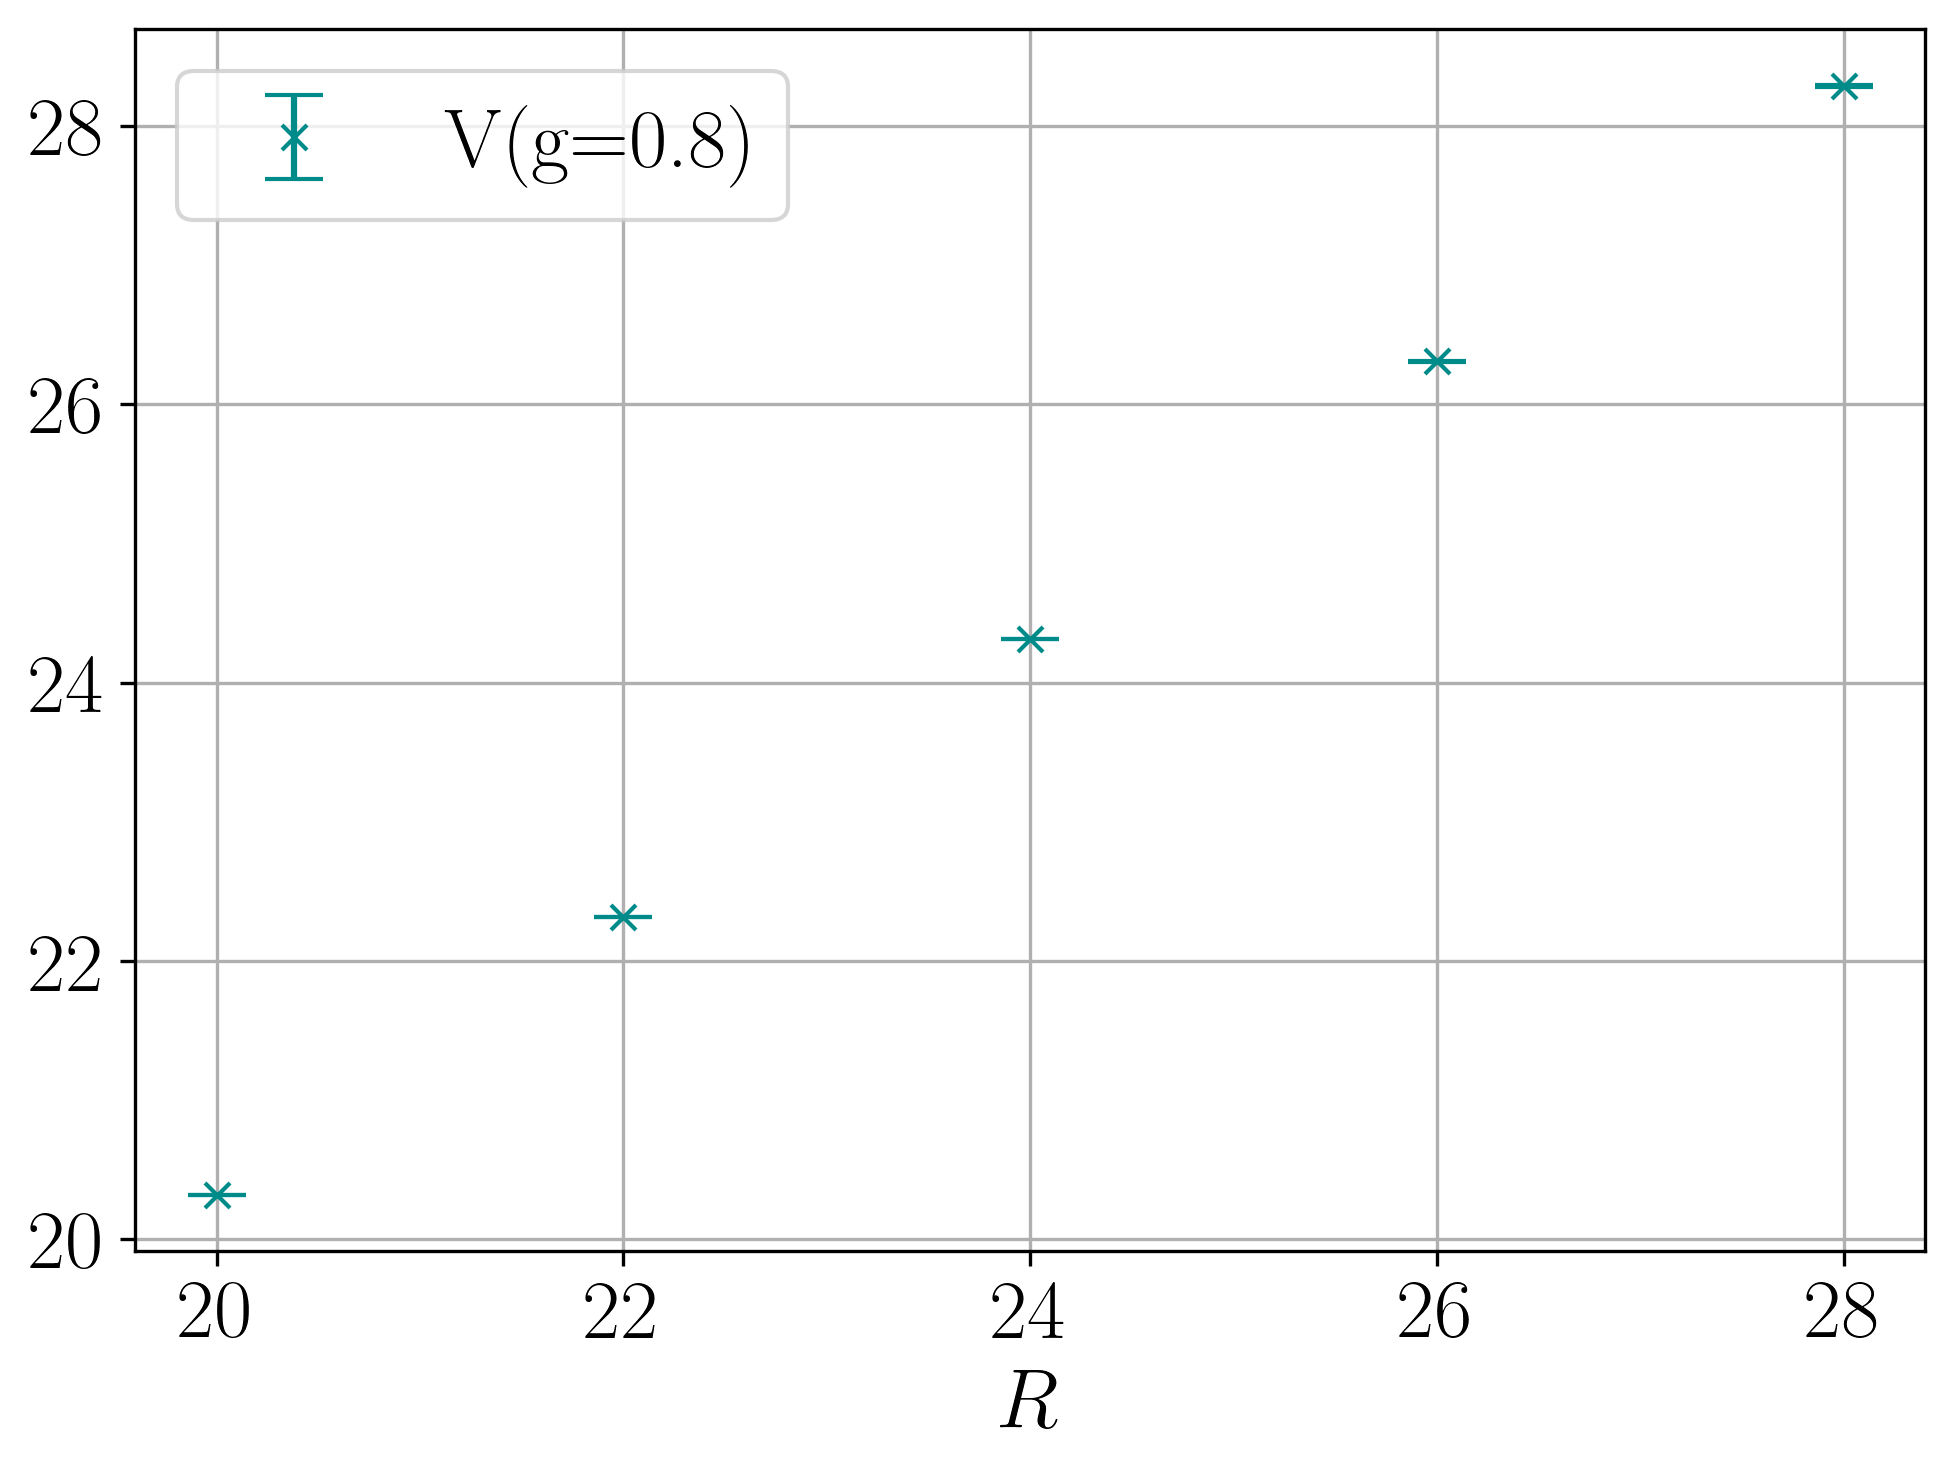

In [6]:
plt.errorbar(Rs, potentials, yerr=potentials_err, fmt='x', color='darkcyan', capsize=7, label=f"V(g={round(g,2)})")
plt.legend()
plt.xlabel("$R$")
plt.grid(True)
plt.show()

### Get $\gamma$ and $\sigma$ for one value of coupling

In [7]:
gamma, gamma_err = fit_luscher_term_g(g,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigma, sigma_err = fit_string_tension_g(g,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 20.317405445986292
Error propagation in the Average: 4.263225544619046e-05
R: 22
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 22.314622678545295
Error propagation in the Average: 5.452672153812293e-05
R: 24
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 24.311779554484247
Error propagation in the Average: 7.059473517218158e-05
R: 26
The ratio R/L: 0.52 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 26.307487 ± 0.000692
R: 28
The ratio R/L: 0.56 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 28.289018 ± 0.008063
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Ari

In [8]:
(gamma, gamma_err), (sigma, sigma_err)

((-0.2044568326894363, 0.3417188529068202),
 (0.9981582639707433, 0.0007223879609182621))

### Get $\gamma$ and $\sigma$ spanning in the coupling phase space

In [9]:
gs = interval
Rs = [20,22,24,26,28]
gammas, gammas_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 20.317405445986292
Error propagation in the Average: 4.263225544619046e-05
R: 22
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 22.314622678545295
Error propagation in the Average: 5.452672153812293e-05
R: 24
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 24.311779554484247
Error propagation in the Average: 7.059473517218158e-05
R: 26
The ratio R/L: 0.52 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 26.307487 ± 0.000692
R: 28
The ratio R/L: 0.56 exceeds the threshold ratio: 0.8

Consider taking smaller Rs, computing the potential with linear fit
y0 (asymptotic value in 1/L) = 28.289018 ± 0.008063
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Ari

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/3581634383.py:1: SyntaxWarning: invalid escape sequence '\g'
  plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/3581634383.py:2: SyntaxWarning: invalid escape sequence '\g'
  plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")


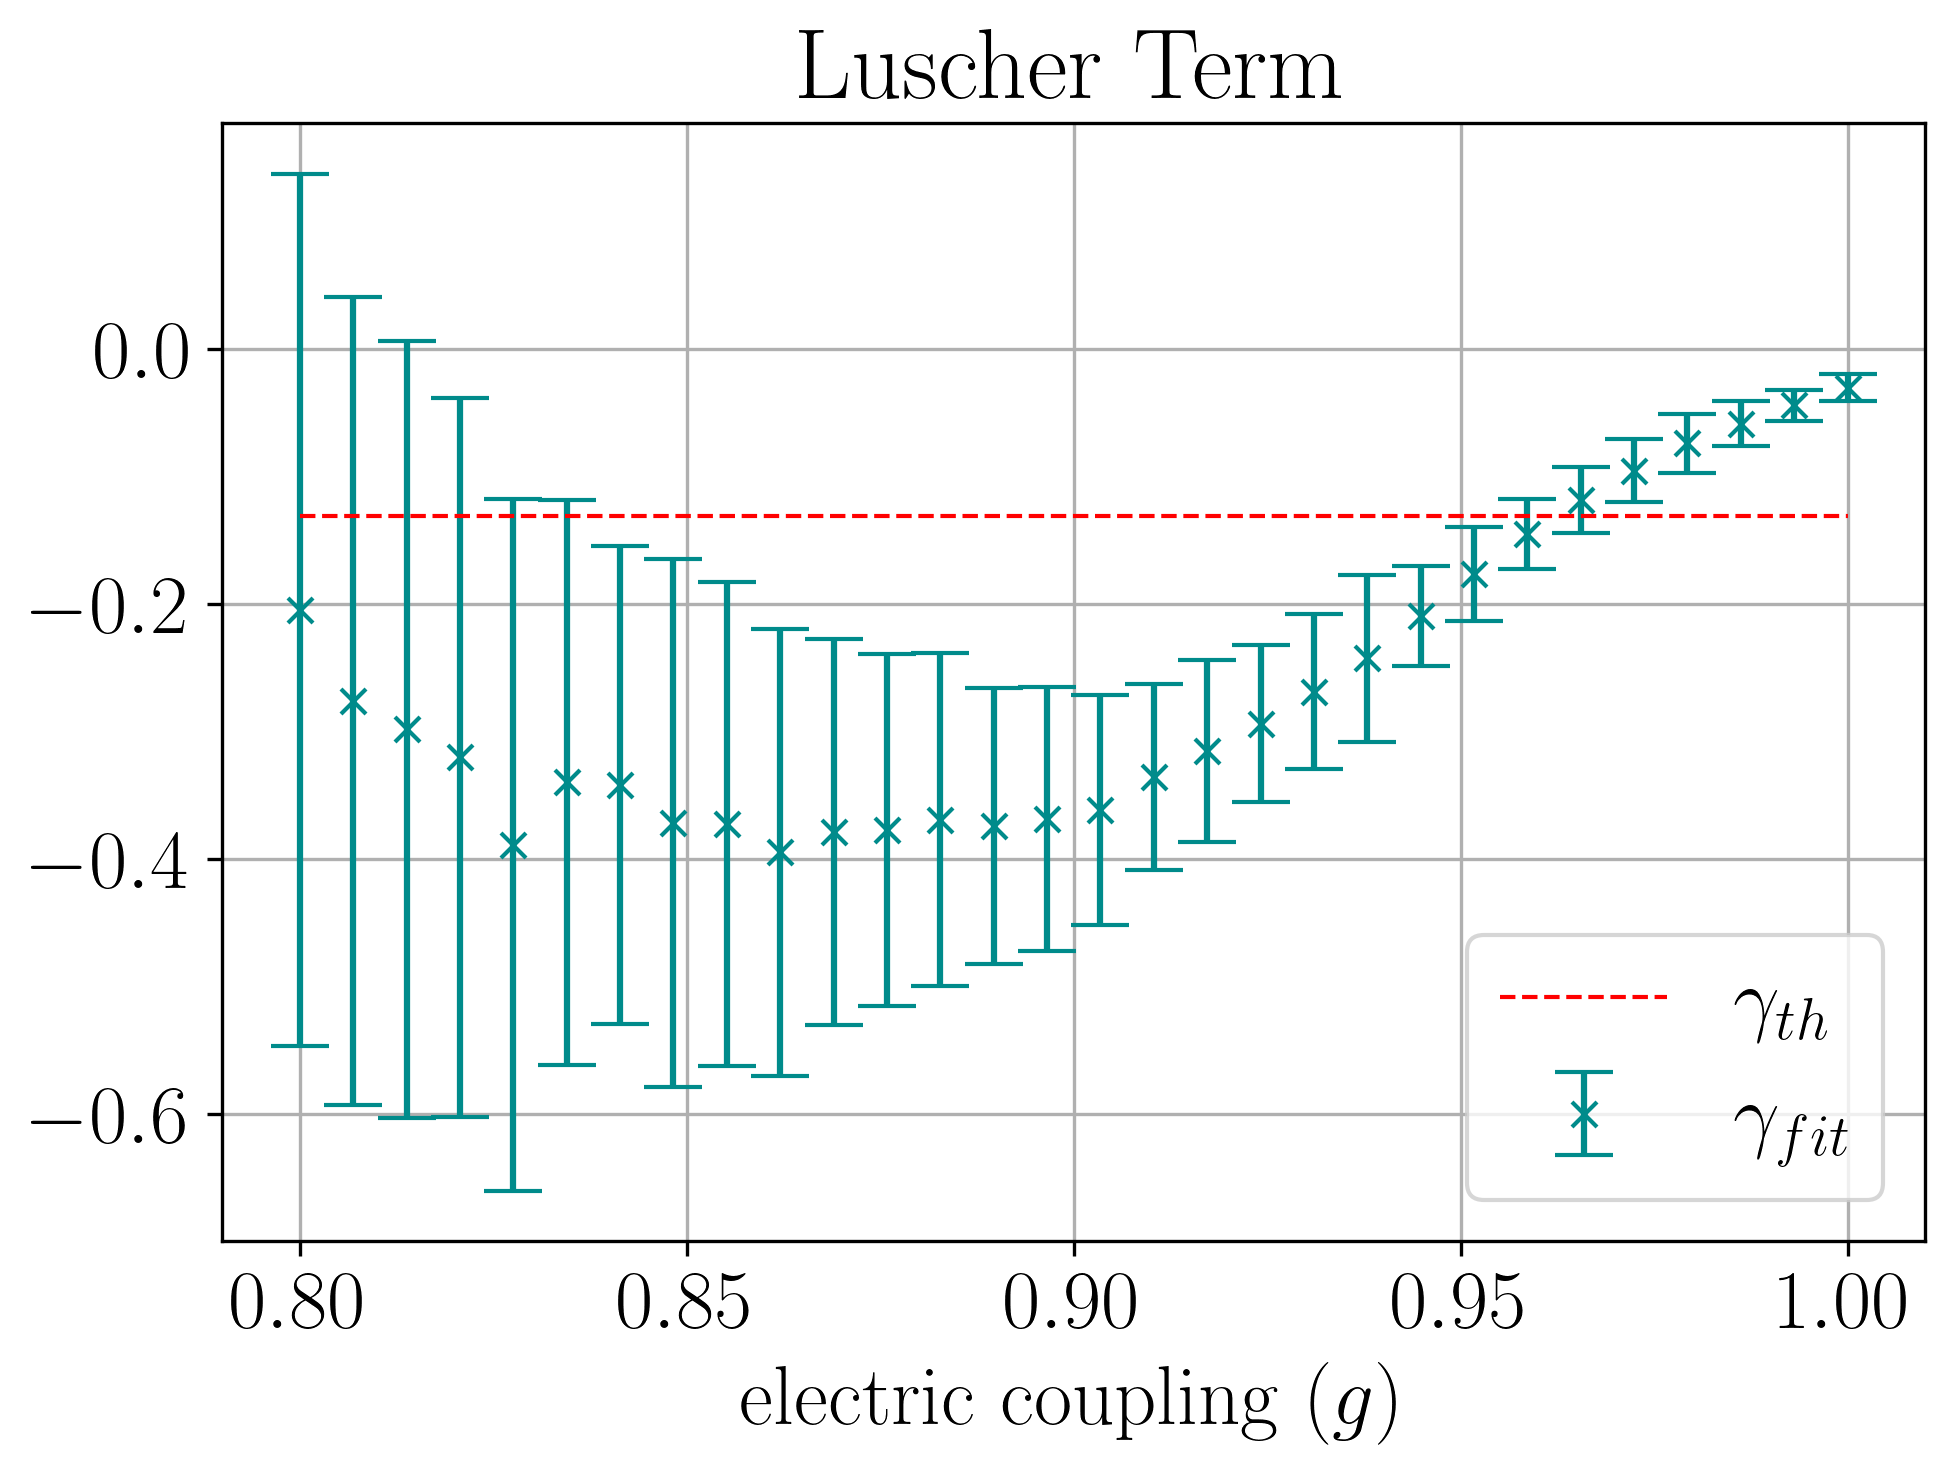

In [10]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term")
plt.grid(True)
plt.legend()
plt.show()

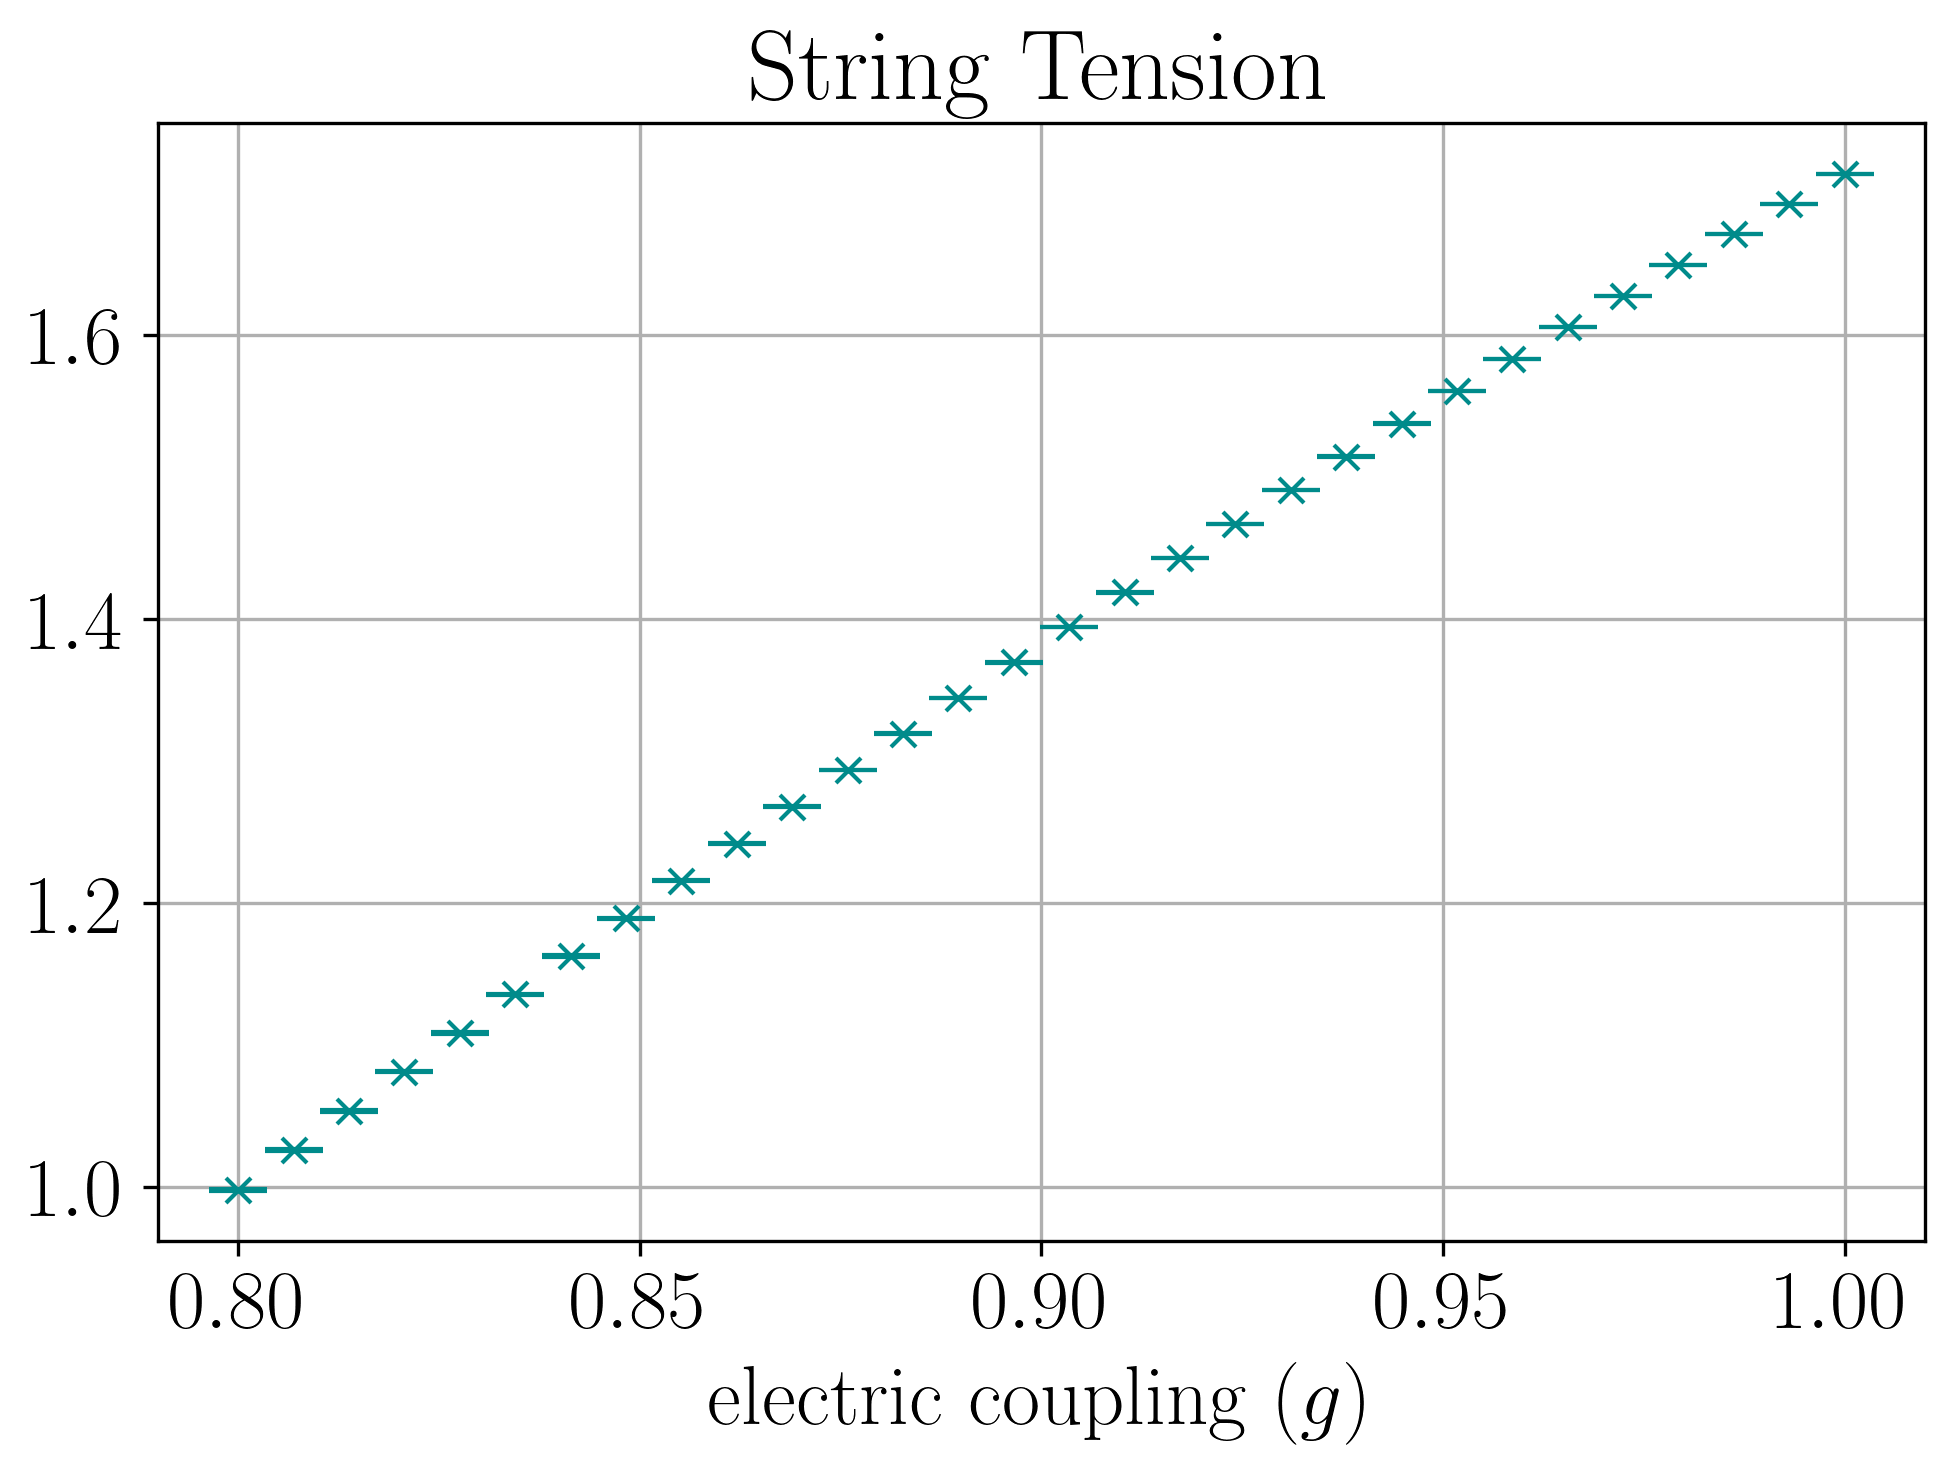

In [11]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension")
plt.grid(True)
plt.show()

# $OBC$ $vs$ $PBC$

### Get $\gamma$ and $\sigma$ for OBC

In [16]:
# free param
chis = [16,32,64,128]
# Ls = [40,50]
# Rs = [20,22,24,26,28]
Ls = [30]
Rs = [18,20,22,24]

# secondary fixed params
bc = "obc"
# npoints, h_i, h_f = 30, 0.8, 1.0
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 3

In [17]:
gammas, gammas_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.1616016083702334
Error propagation in the Average: 2.1884716261411086e-12
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.17900720608531628
Error propagation in the Average: 9.55866681806583e-07
R: 22
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.19648971599002607
Error propagation in the Average: 8.237149984324788e-07
R: 24
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.21436165018815245
Error propagation in the Average: 8.301223601847596e-06
R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.2016602425450742
Error propagation in the Average: 2.6716406864579767e-12
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic a

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/3835370503.py:1: SyntaxWarning: invalid escape sequence '\g'
  plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/3835370503.py:2: SyntaxWarning: invalid escape sequence '\g'
  plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")


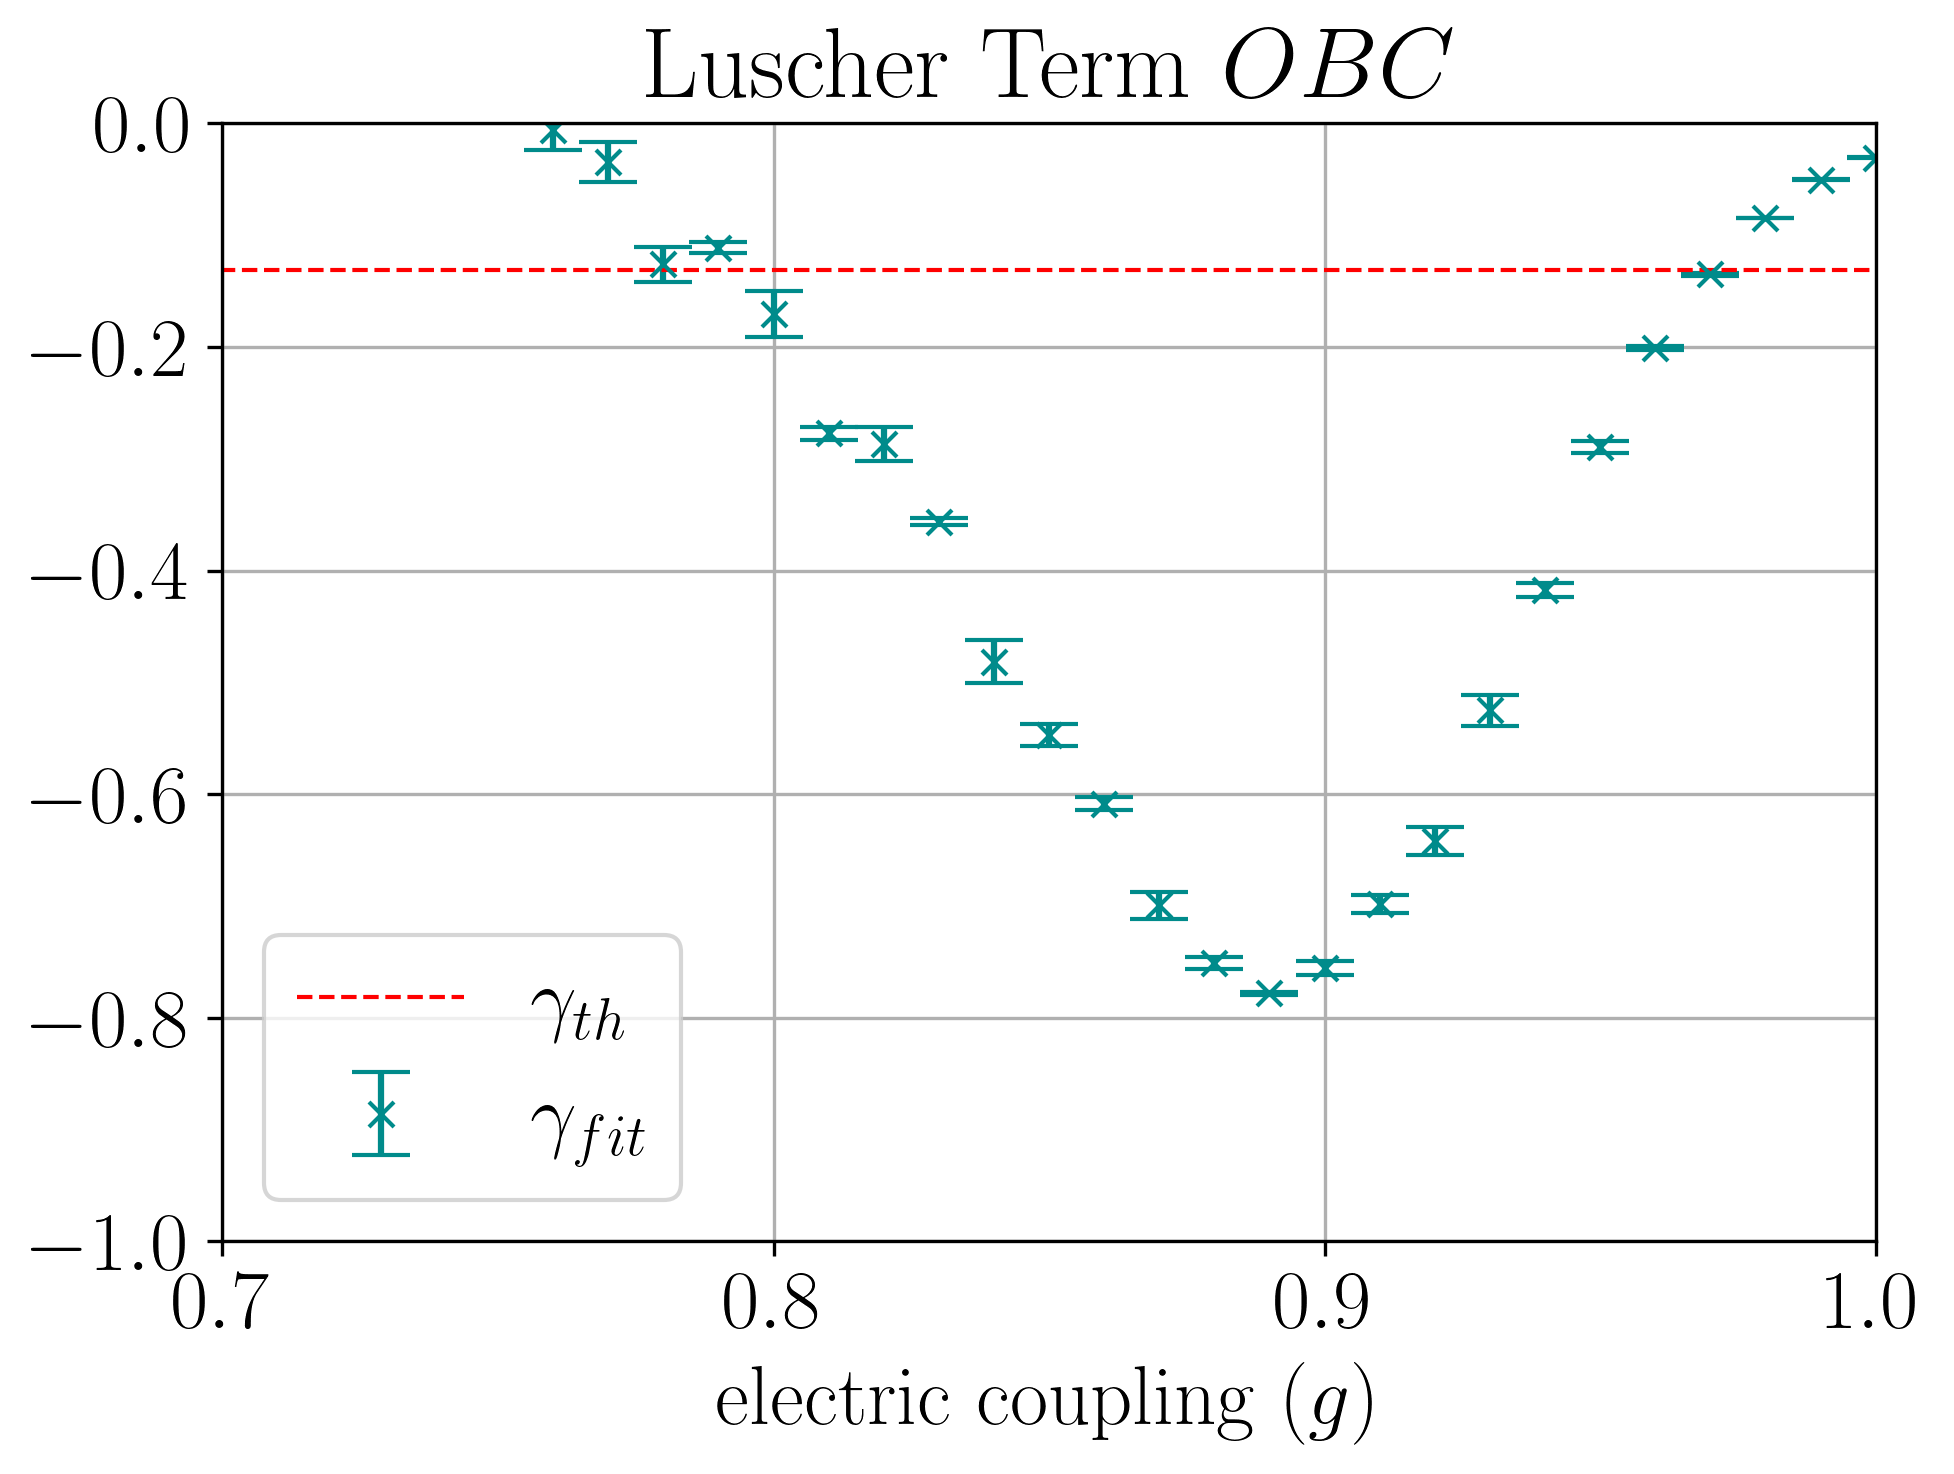

In [23]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term $OBC$")
plt.grid(True)
plt.legend()
plt.xlim(0.7,1.0)
plt.ylim(-1,0)
plt.show()

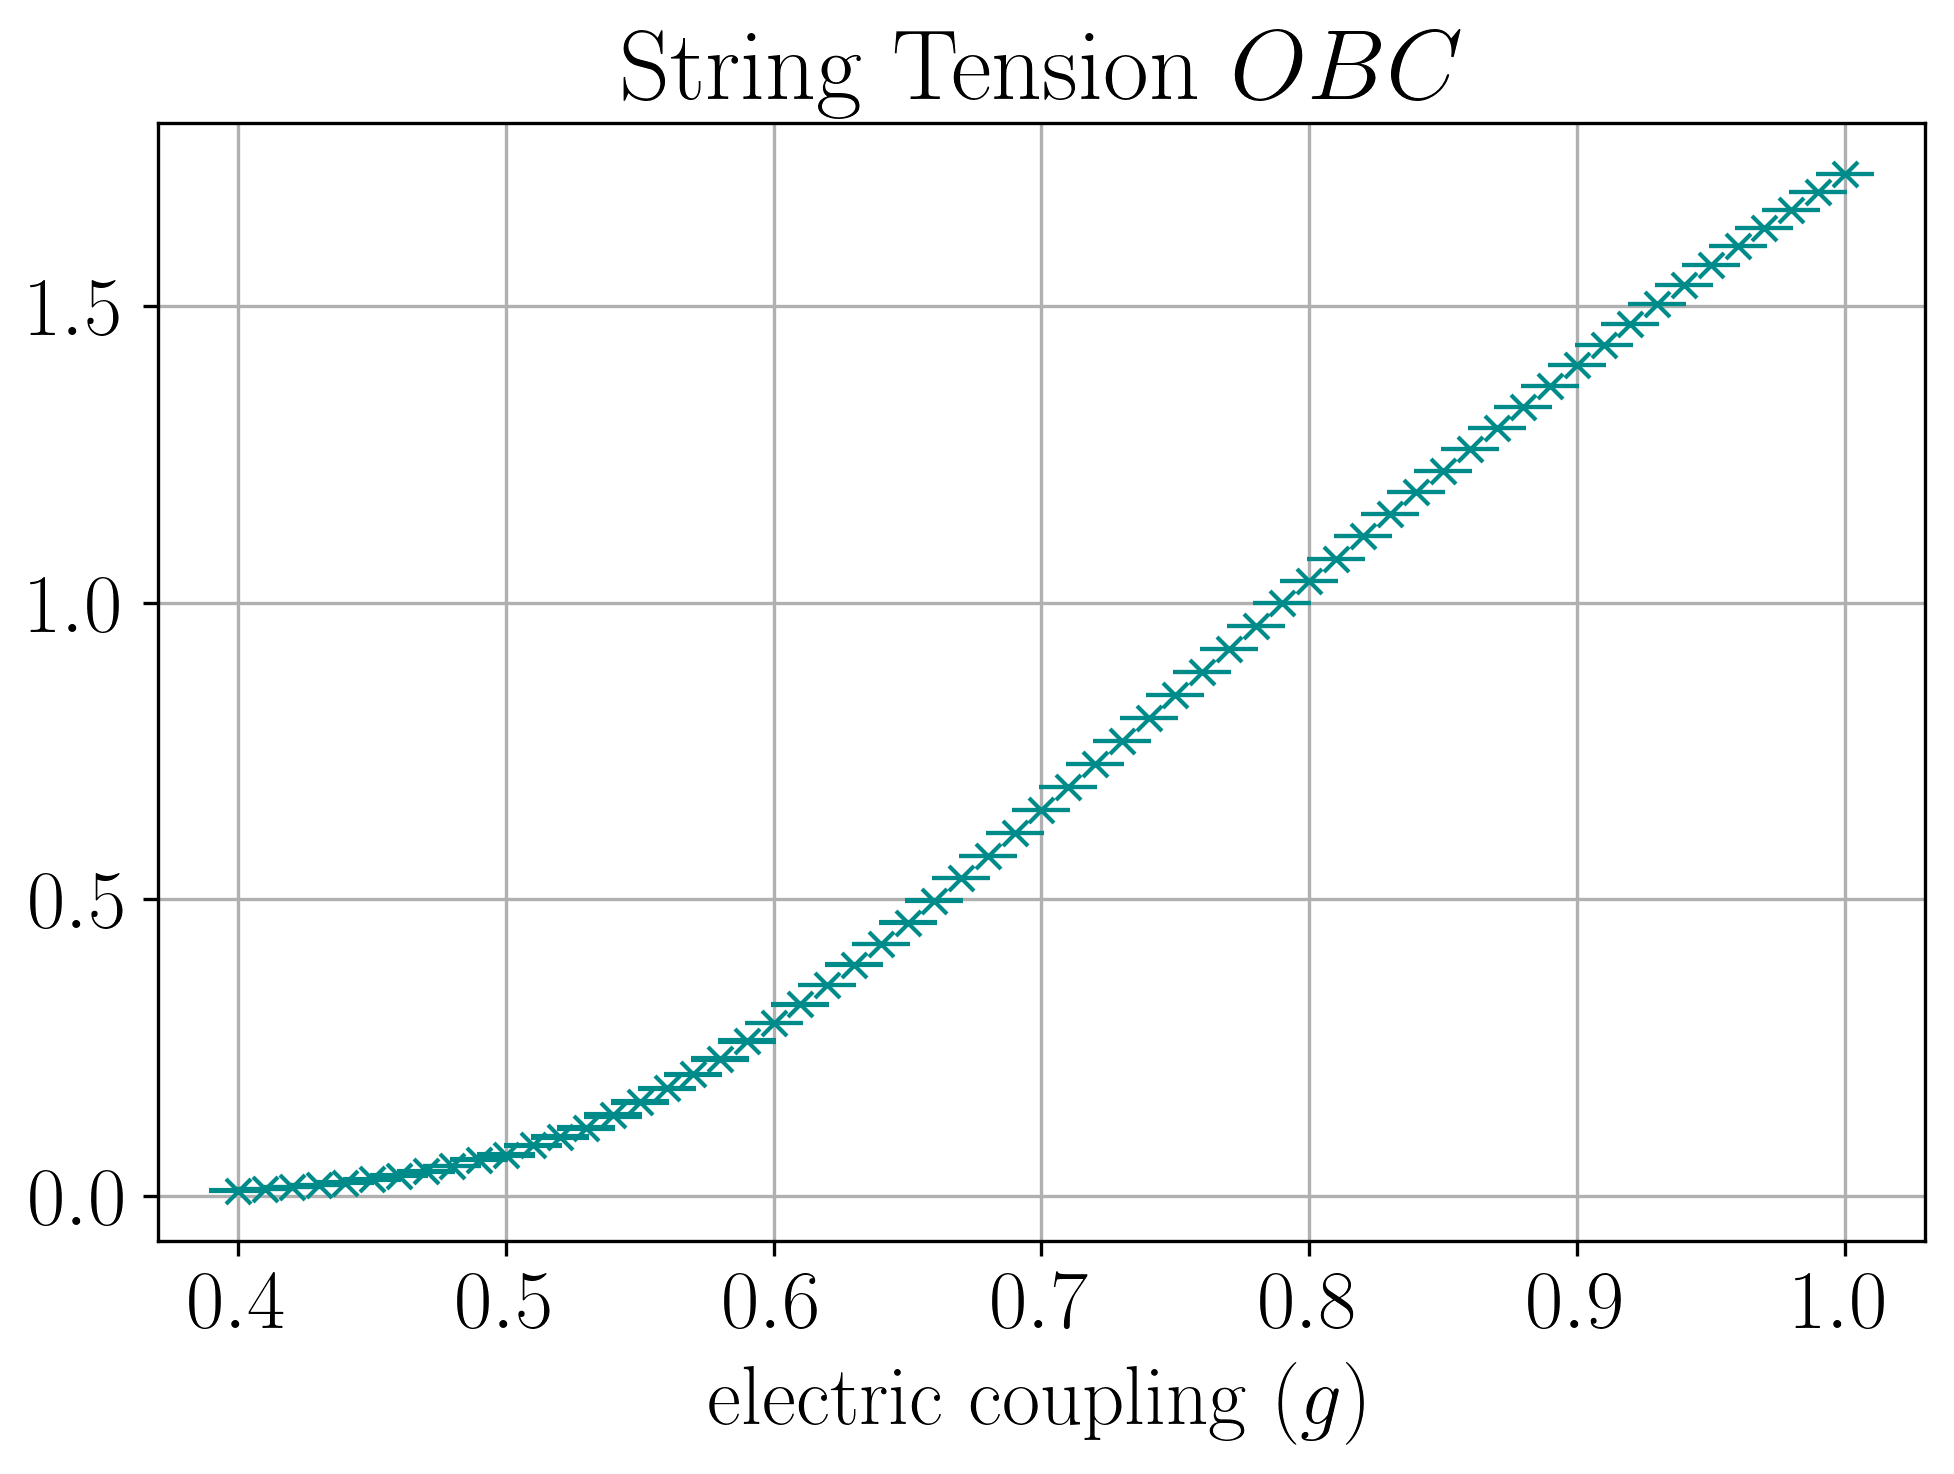

In [24]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension $OBC$")
plt.grid(True)
plt.show()

### Get $\gamma$ and $\sigma$ for PBC


In [25]:
# free param
chis = [16,32,64,128]
Ls = [30]
Rs = [18,20,22,24]

# secondary fixed params
bc = "pbc"
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 3

In [26]:
gammas, gammas_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
sigmas, sigmas_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.16046027537854002
Error propagation in the Average: 1.1777698858850272e-05
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.17803224279961682
Error propagation in the Average: 1.1644394561471927e-05
R: 22
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.1956133775072999
Error propagation in the Average: 2.545825481092834e-06
R: 24
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.21319348331803667
Error propagation in the Average: 1.1824601244825317e-06
R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.1842916242663648
Error propagation in the Average: 7.306451550448401e-07
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/2251296939.py:1: SyntaxWarning: invalid escape sequence '\g'
  plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, linewidth=1, label="$\gamma_{fit}$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/2251296939.py:2: SyntaxWarning: invalid escape sequence '\g'
  plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")


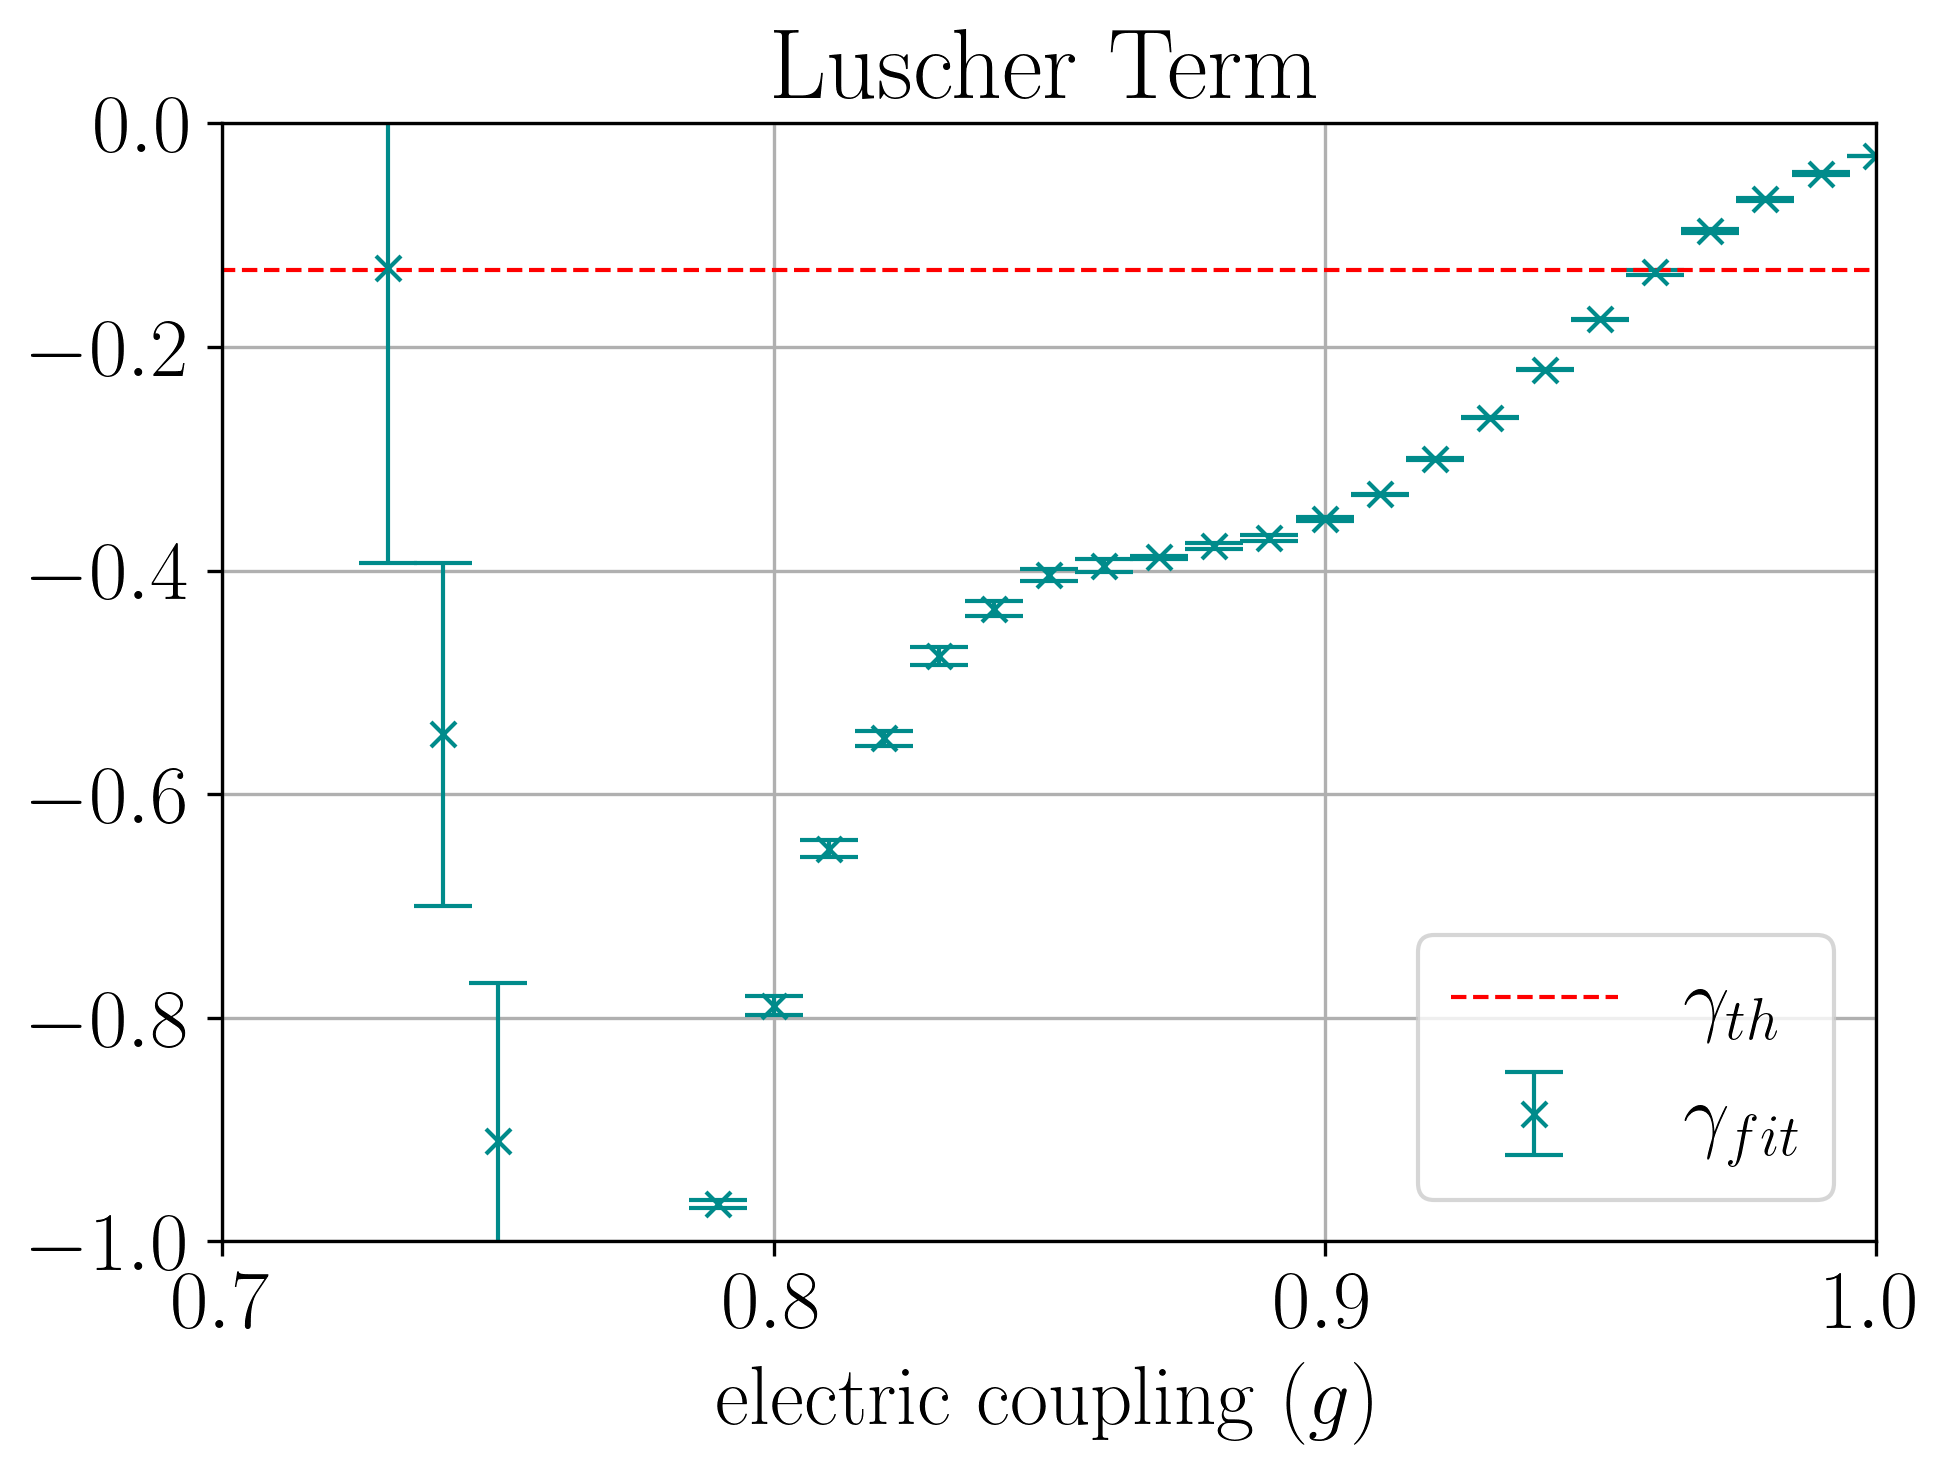

In [28]:
plt.errorbar(gs, gammas, yerr=gammas_err, fmt='x', color='darkcyan', capsize=7, linewidth=1, label="$\gamma_{fit}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term")
plt.grid(True)
plt.legend()
plt.xlim(0.7,1.0)
plt.ylim(-1,0)
plt.show()

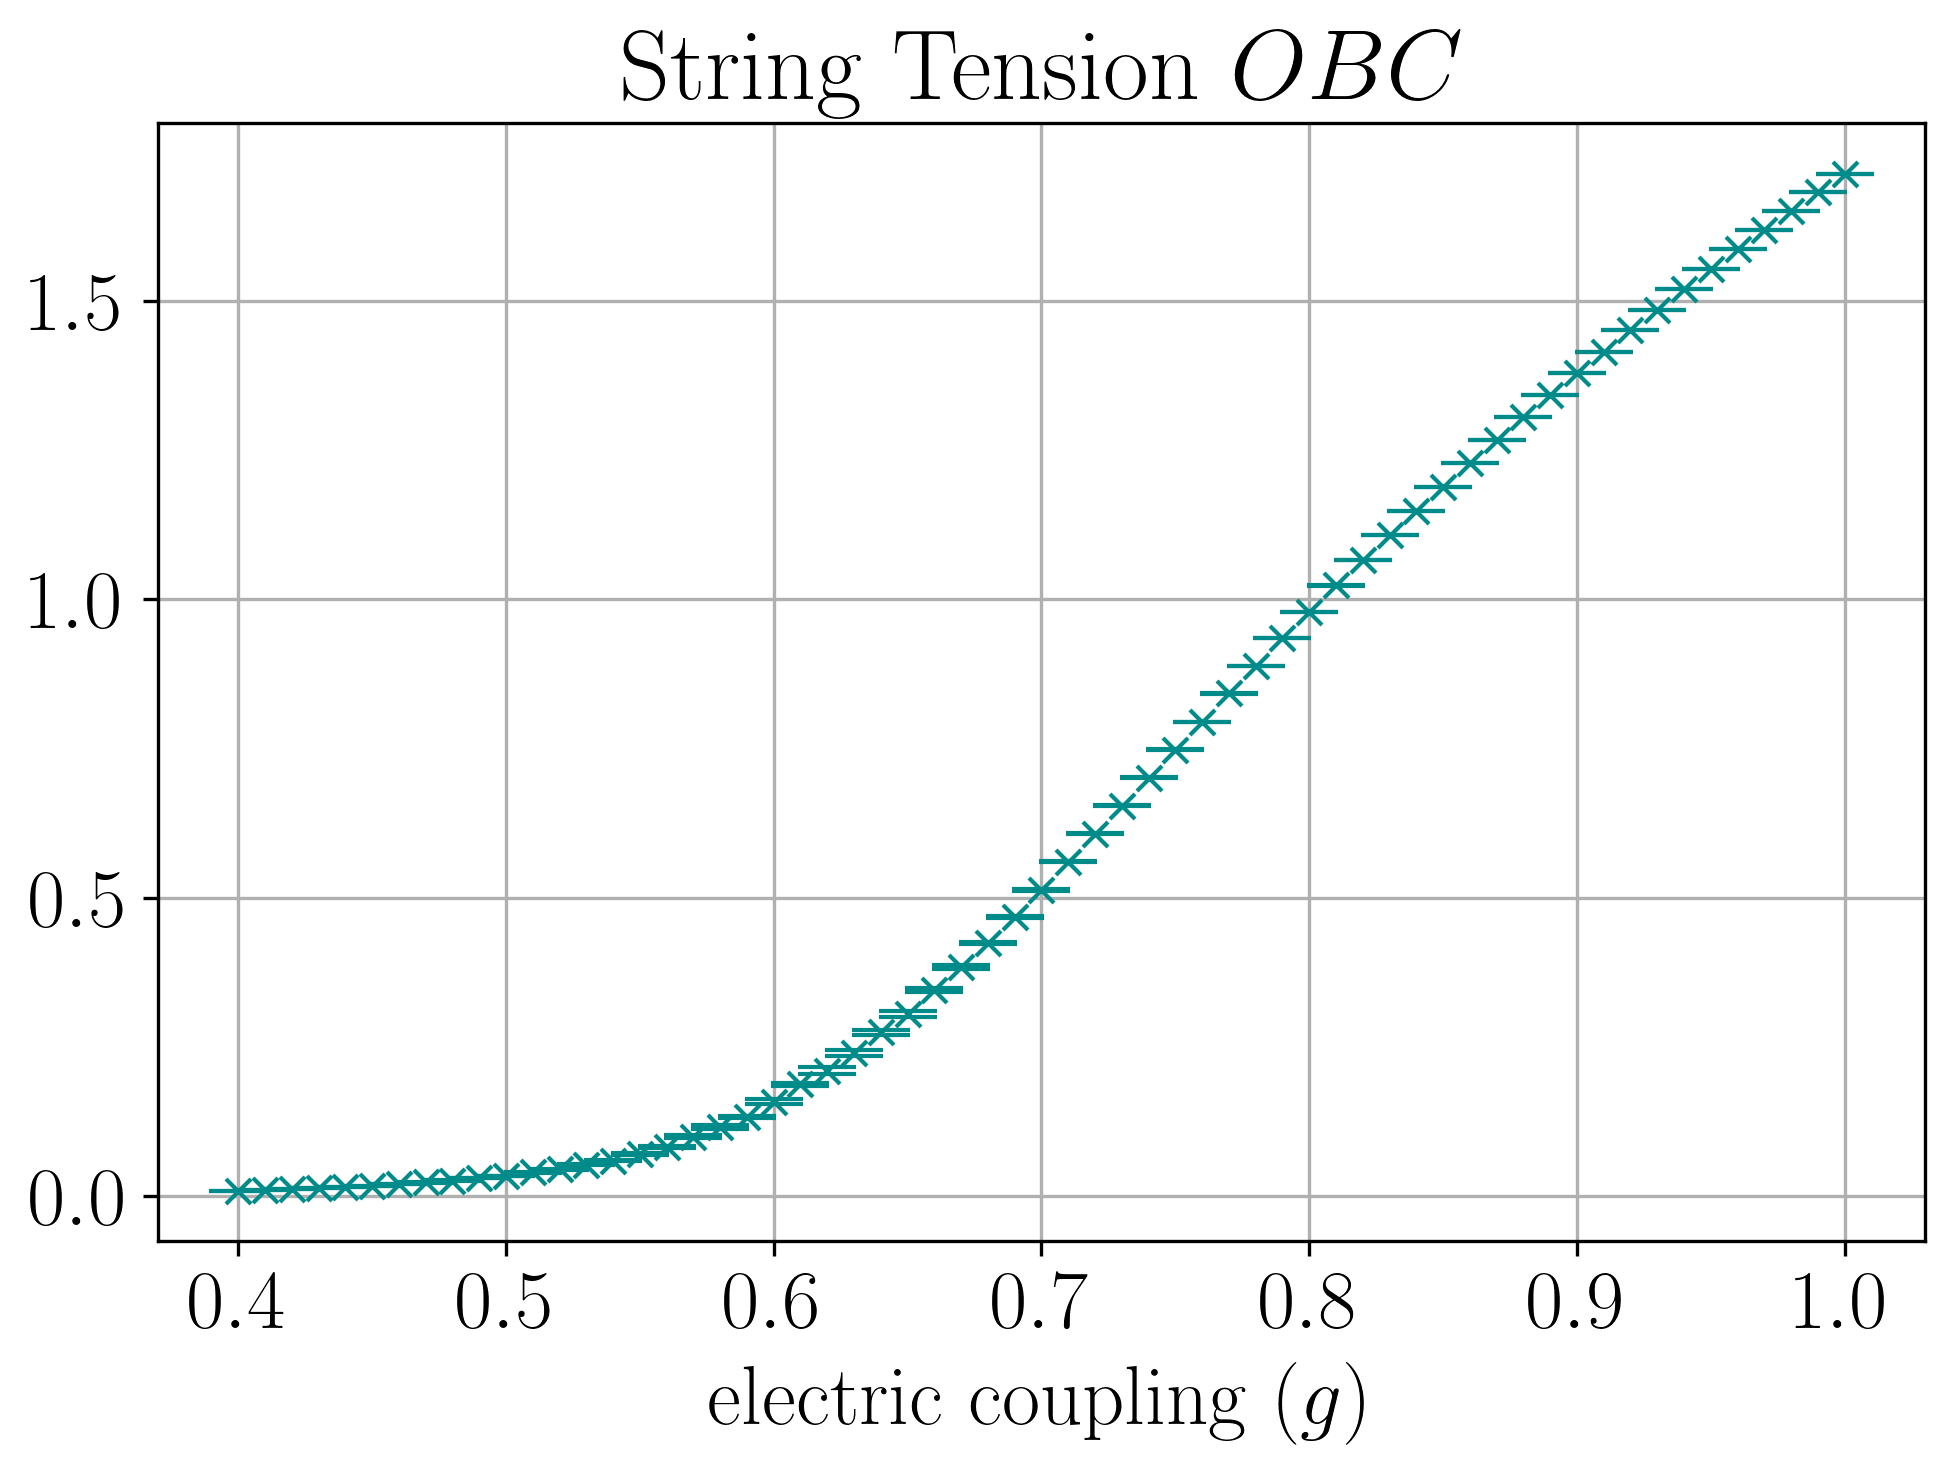

In [29]:
plt.errorbar(gs, sigmas, yerr=sigmas_err, fmt='x', color='darkcyan', capsize=7)
plt.xlabel("electric coupling $(g)$")
plt.title("String Tension $OBC$")
plt.grid(True)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/2202237553.py:23: SyntaxWarning: invalid escape sequence '\g'
  plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, fmt='p', markersize=5, color=colors[i], capsize=7, linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_19578/2202237553.py:24: SyntaxWarning: invalid escape sequence '\g'
  plt.errorbar(gs, gammas_obc, yerr=gammas_obc_err, fmt='v', markersize=5, color=colors[i], capsize=7, linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ip

R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.16047205307739887
Error propagation in the Average: 1.6768808563938364e-12
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.1780438871941783
Error propagation in the Average: 7.673861546209082e-13
R: 22
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.195615923332781
Error propagation in the Average: 1.7337242752546445e-12
R: 24
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.2131923008579122
Error propagation in the Average: 1.9042545318370685e-12
R: 18
Negligible boundary effects in L

Computing the potential with arithmetic average
Arithmetic Average: 0.18429235491151985
Error propagation in the Average: 6.821210263296962e-13
R: 20
Negligible boundary effects in L

Computing the potential with arithmetic a

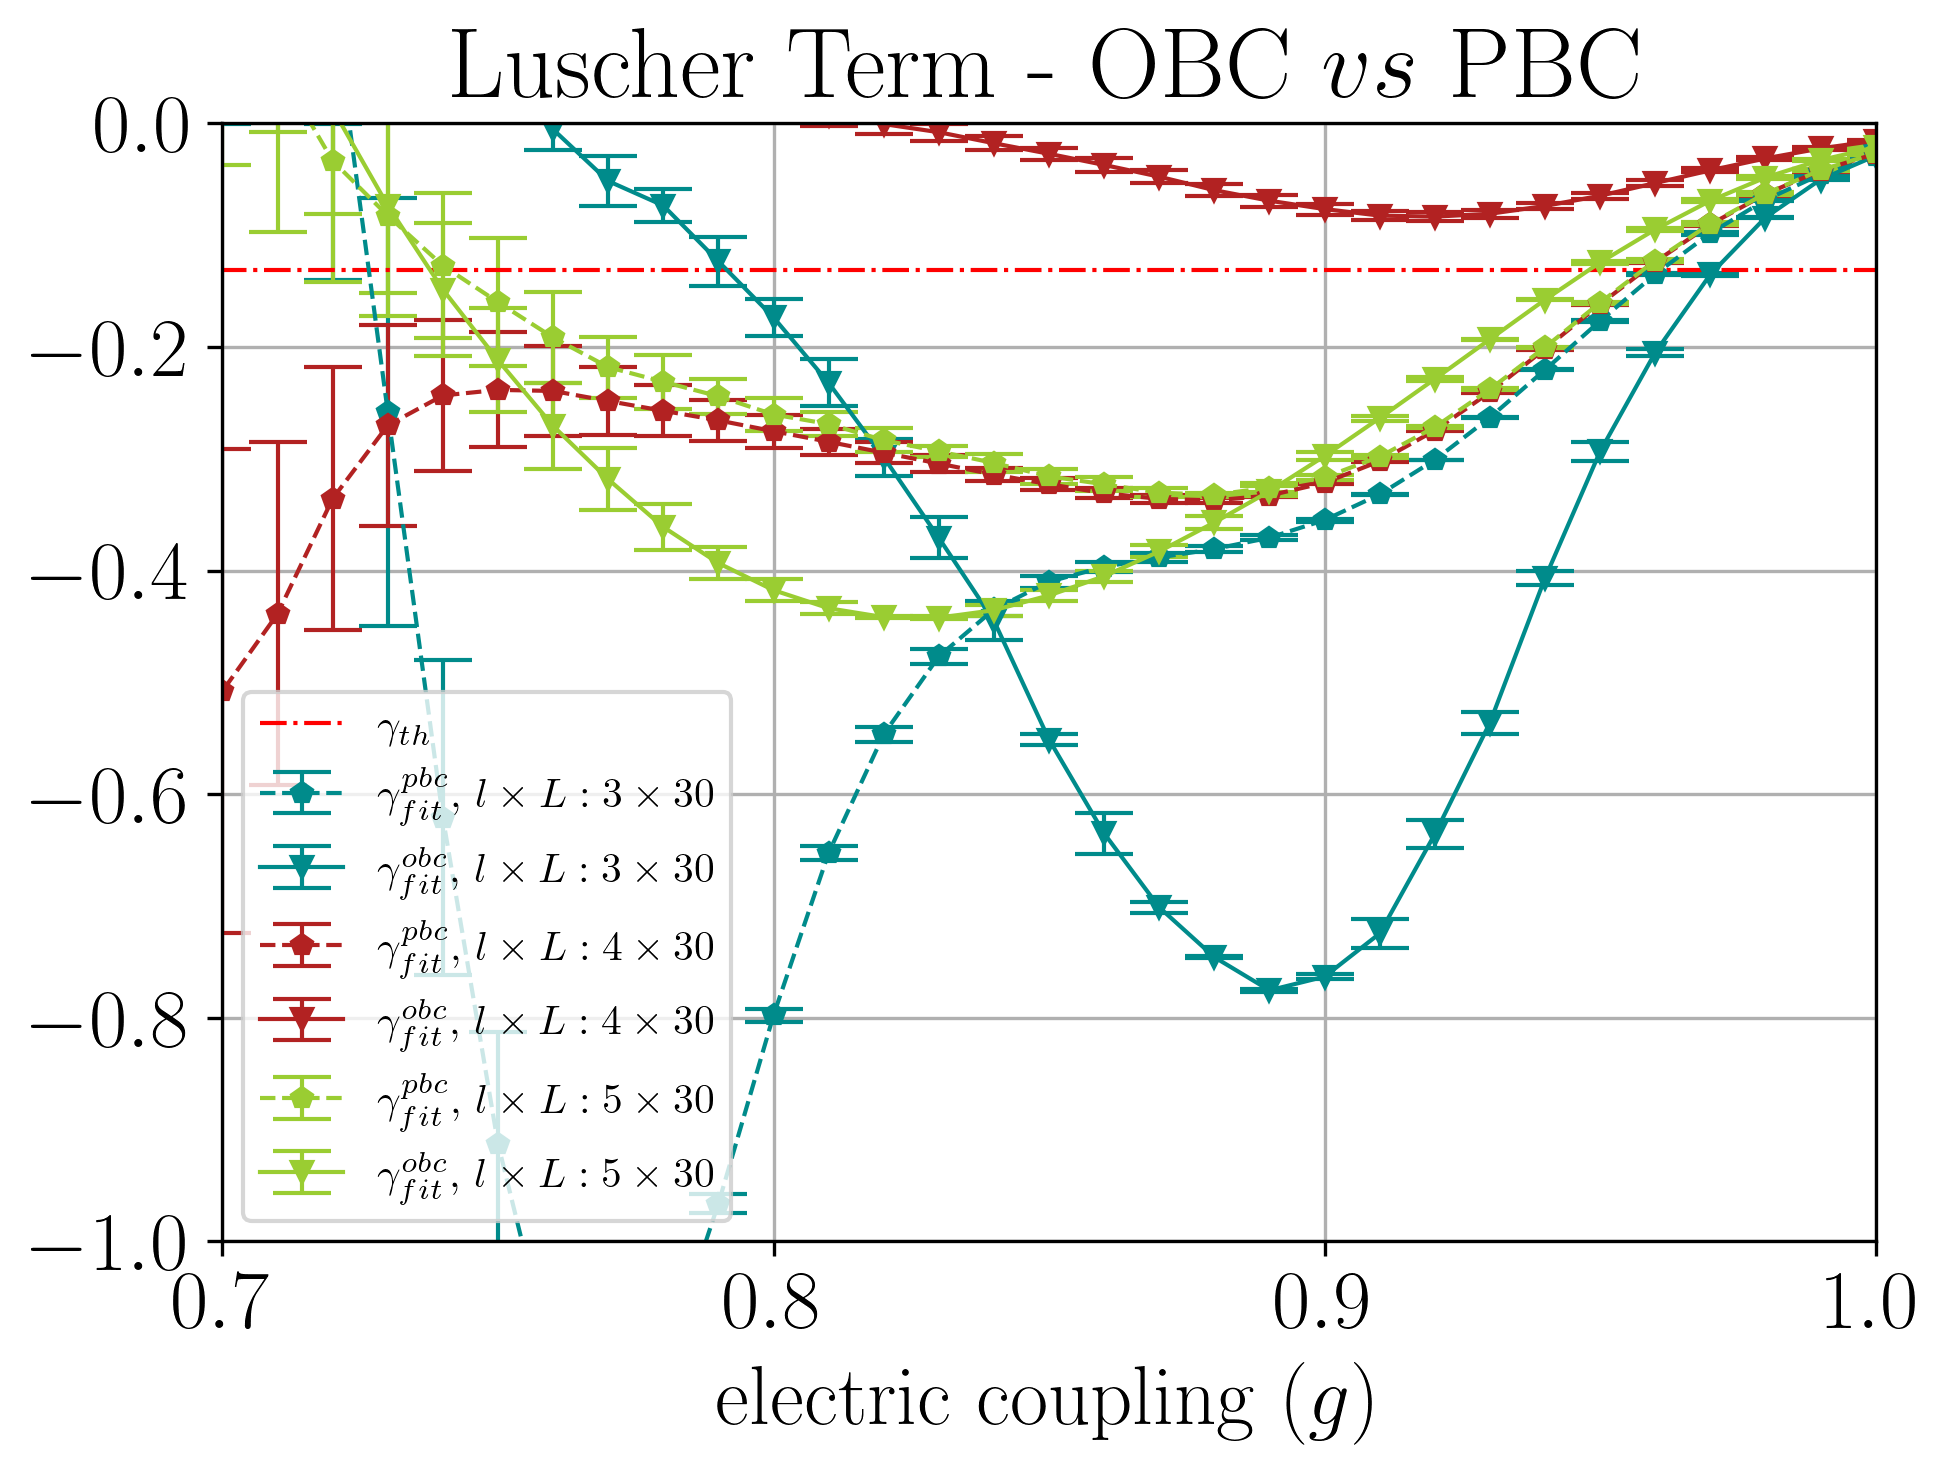

In [38]:
ls = [3,4,5]

# free param
chis = [16,32,64]
Ls = [30]
L = 30
Rs = [18,20,22,24]

# secondary fixed params
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

colors = ["darkcyan", "firebrick", "yellowgreen"]
for i, l in enumerate(ls):
    bc = "pbc"
    gammas_pbc, gammas_pbc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    sigmas_pbc, sigmas_pbc_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    bc = "obc"
    gammas_obc, gammas_obc_err = fit_luscher(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)
    sigmas_obc, sigmas_obc_err = fit_string_tension(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path_tensor)

    plt.errorbar(gs, gammas_pbc, yerr=gammas_pbc_err, fmt='p', markersize=5, color=colors[i], capsize=7, linestyle="--", linewidth=1, label="$\gamma_{fit}^{pbc}$"+f", $l \\times L:{l}\\times{L}$")
    plt.errorbar(gs, gammas_obc, yerr=gammas_obc_err, fmt='v', markersize=5, color=colors[i], capsize=7, linestyle="-", linewidth=1, label="$\gamma_{fit}^{obc}$"+f", $l \\times L:{l}\\times{L}$")
plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linewidth=1, label="$\gamma_{th}$")
plt.xlabel("electric coupling $(g)$")
plt.title("Luscher Term - OBC $vs$ PBC")
plt.grid(True)
plt.legend(fontsize=10)
plt.xlim(0.7,1.0)
plt.ylim(-1,0)
plt.show()

# Fluxtube of the electric field

In [3]:
def compute_correlation_function_vacuum():
    corr_vacuum = []
    for h in interval:
        print(f"Correlator - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        corr = lattice_mps.connected_correlator(site=L//2, lad=3)
        corr_vacuum.append(corr)
    return corr_vacuum

def compute_electric_energy_density_vacuum():
    eed_vacuum = []
    for h in interval:
        print(f"Energy Density - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        eed = lattice_mps.electric_energy_density_Z2(site=L//2-1)
        eed_vacuum.append(eed)
    return eed_vacuum


def compute_correlation_function_charges():
    corr_charges = []
    for h in interval:
        print(f"Correlator - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=charges_x, cy=charges_y)
        corr = lattice_mps.connected_correlator(site=L//2, lad=3)
        corr_charges.append(corr)
    return corr_charges

def compute_electric_energy_density_charges():
    eed_charges = []
    for h in interval:
        print(f"Energy Density - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.L = lattice_mps.L - 1
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=charges_x, cy=charges_y)
        eed = lattice_mps.electric_energy_density_Z2(site=L//2-1)
        eed_charges.append(eed)
    return eed_charges

### Compute energy density and correlators

In [ ]:
if endens:
    # compute the connected electric energy density
    eed_charges = compute_electric_energy_density_charges()
    eed_vacuum = compute_electric_energy_density_vacuum()
    eed_conn = (np.array(eed_charges) - np.array(eed_vacuum))

if correl:
    # compute the connected correlation function
    corr_charges = compute_correlation_function_charges()
    corr_vacuum = compute_correlation_function_vacuum()
    corr_conn = (np.array(corr_charges) - np.array(corr_vacuum))


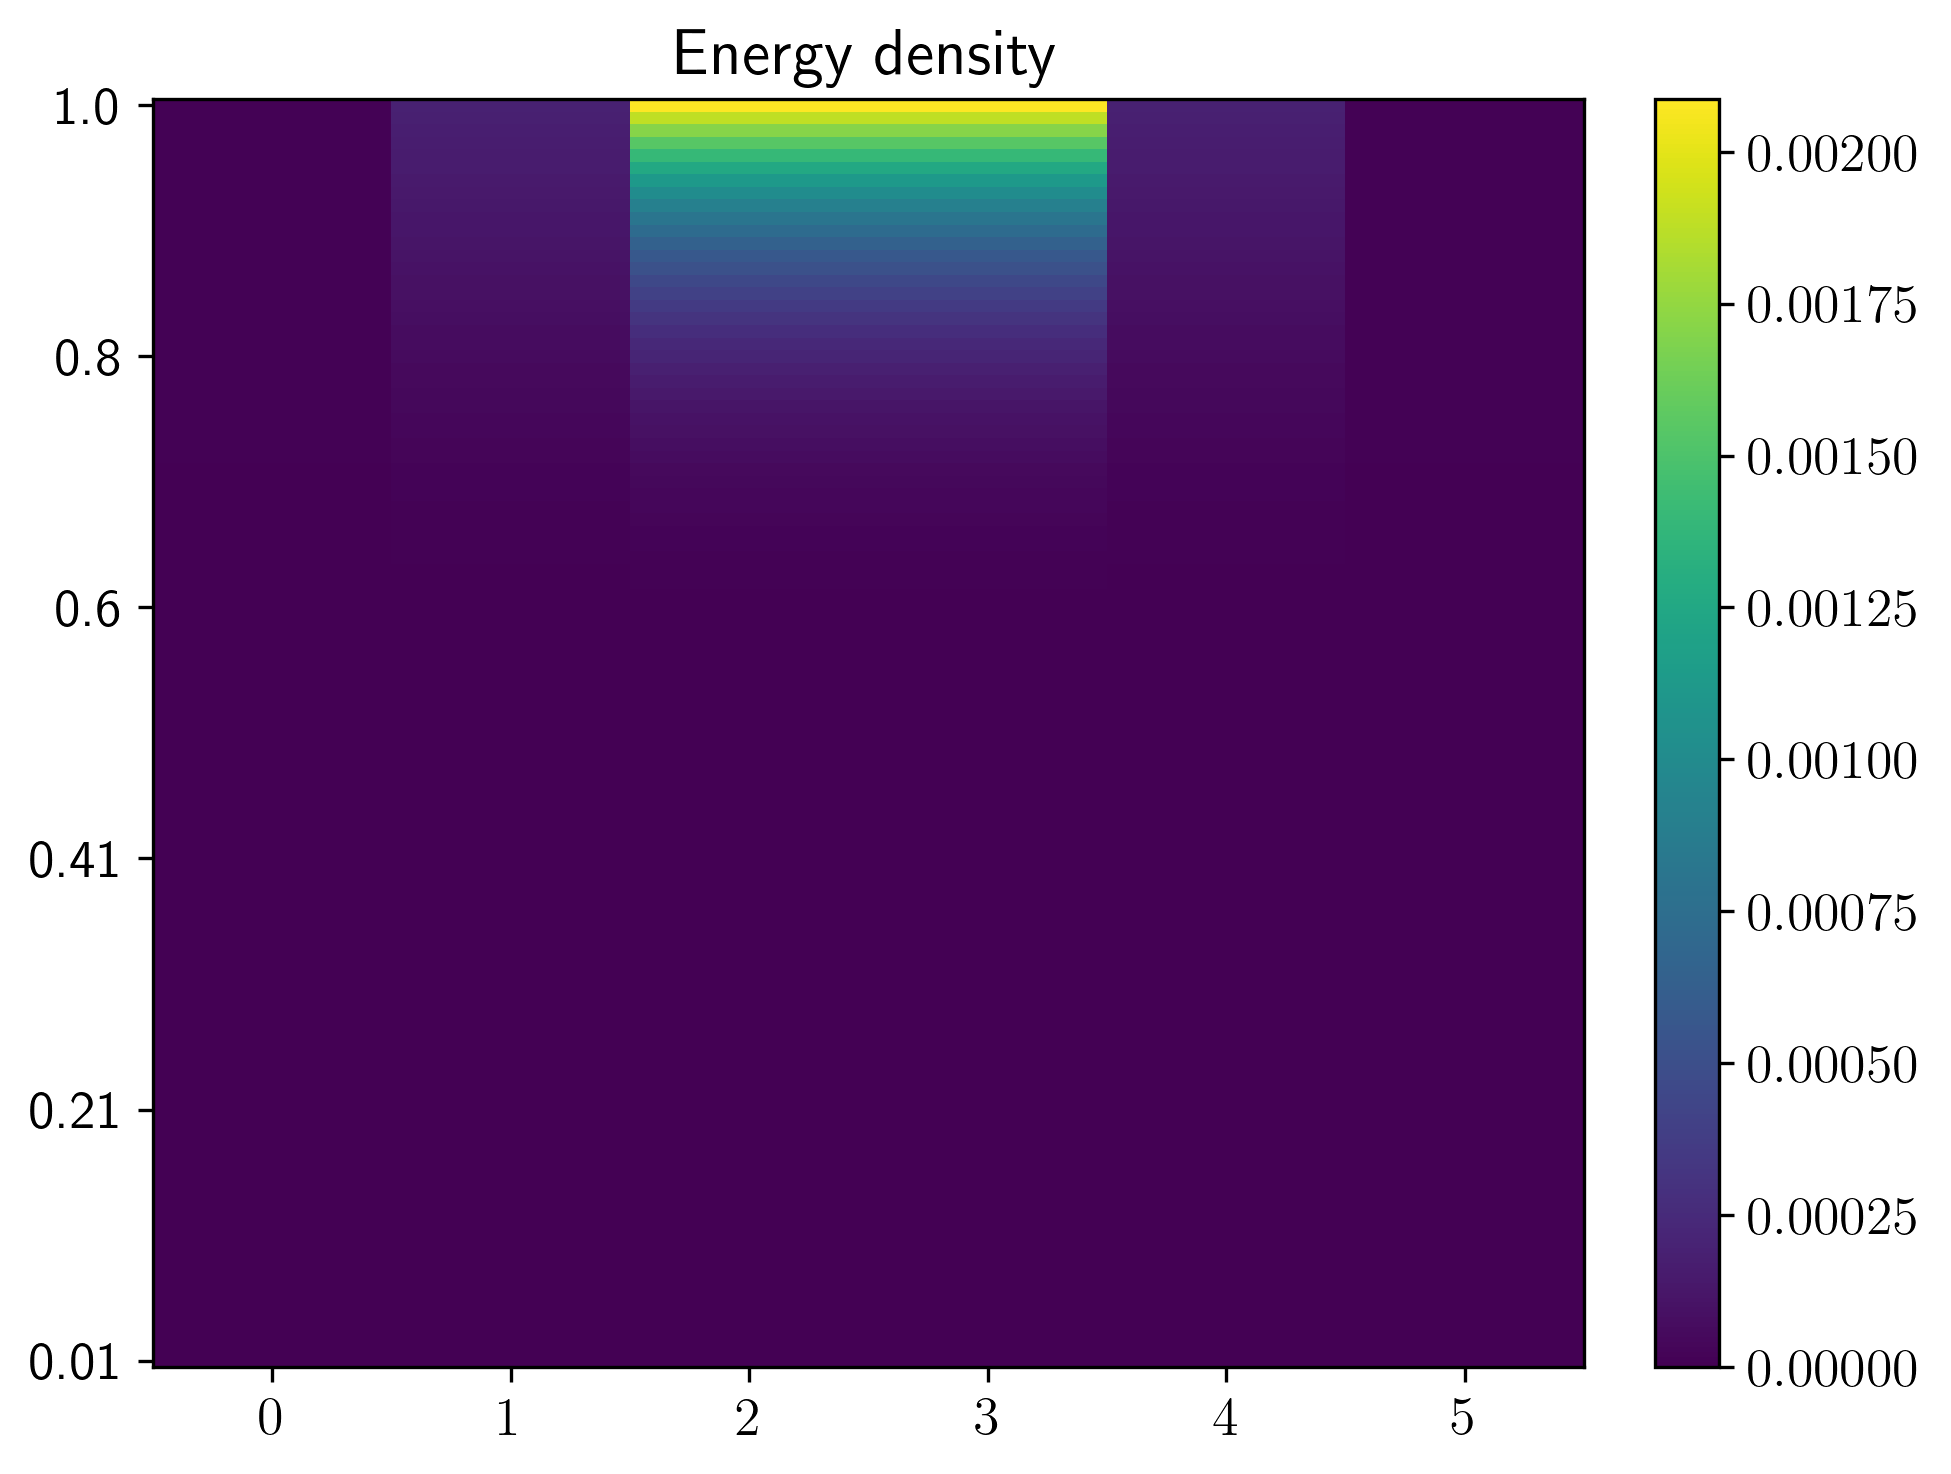

In [ ]:
plt.title(f"Energy density")
plt.imshow(eed_conn, aspect='auto', origin='lower') # , norm=mpl.colors.LogNorm()

# plt.title(f"Correlations")
# plt.imshow(corr_conn, aspect=0.1, origin='lower')

plt.yticks(ticks=np.linspace(0,100,101)[::(len(interval)//5)], labels=[round(h,2) for h in interval[::(len(interval)//5)]])
plt.colorbar()
# plt.savefig(f"{parent_path}/figures/correlators/correlator_{model}_direct_lattice_{l}x{L-1}_{sector}_{charges_x}-{charges_y}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")

## String width

We find the string width as follows

$$\sigma^2 = \frac{\sum_x x^2 \mathcal{E}(x)}{\sum_x \mathcal{E}(x)}$$

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_string = []
xs = [i for i in range(-l//2,l//2+1,) if i!=0]
for eed_lad in eed_conn:
    eed_sum_lad = 0
    for x, eed_x in zip(xs, eed_lad):
        eed_sum_lad += eed_x * ((x)**2)
    eed_sum_lad = eed_sum_lad / sum(eed_lad)
    eed_string.append(eed_sum_lad)


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_2119/3666645651.py:1: SyntaxWarning: invalid escape sequence '\s'
  plt.title("String width $\sigma^2$")


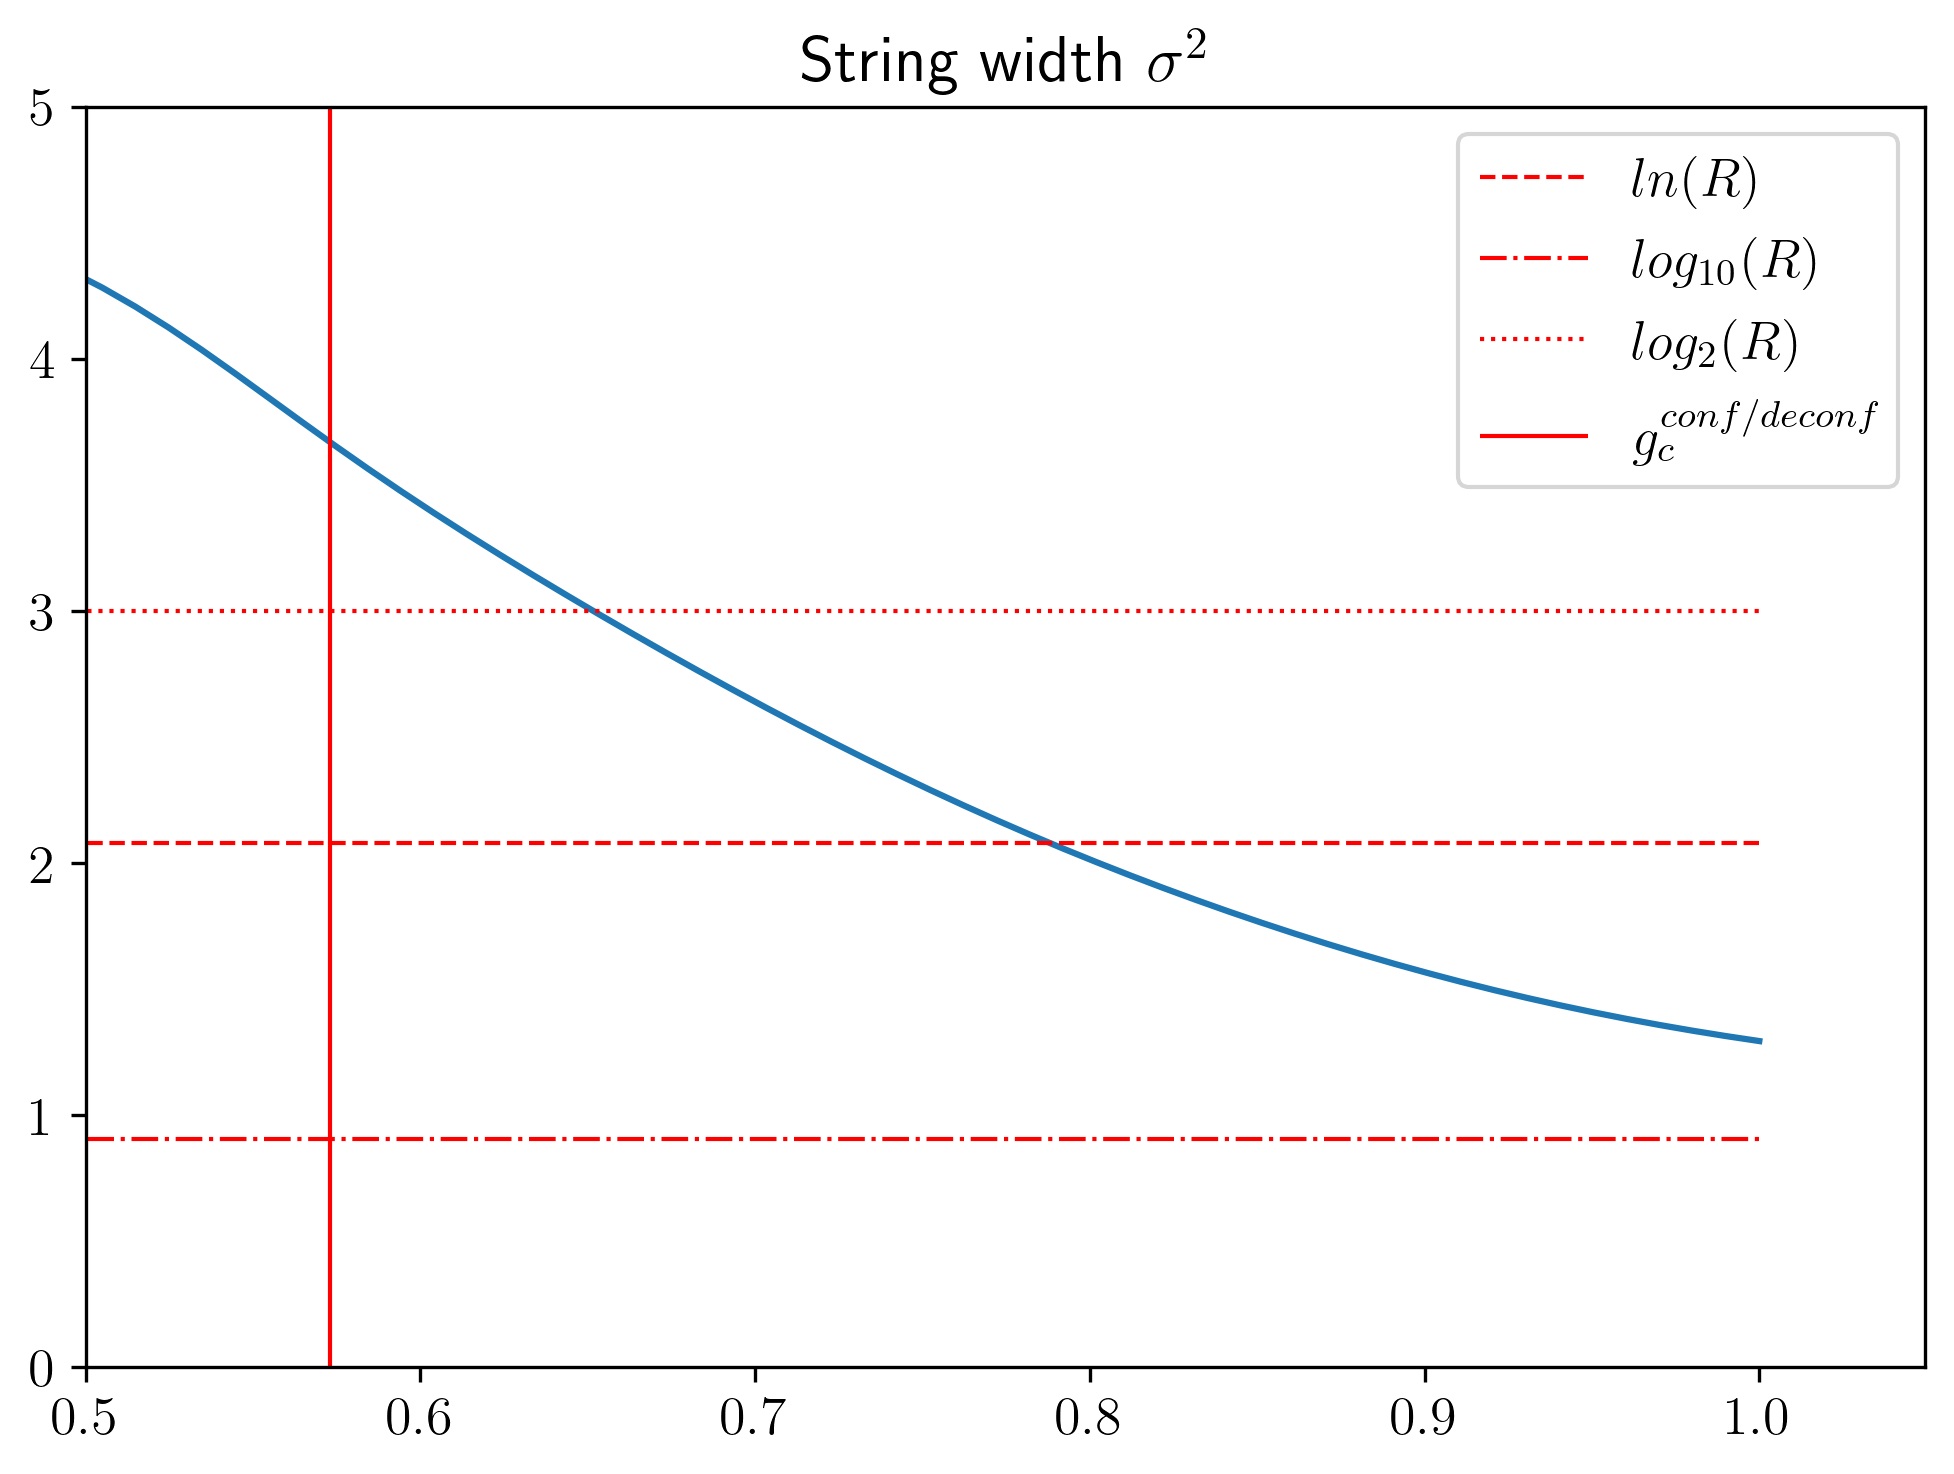

In [ ]:
plt.title("String width $\sigma^2$")
plt.plot(interval, eed_string)
d_string_dh = np.gradient(eed_string[50:], interval[50:])
idx_max = np.argmax(np.abs(d_string_dh))
x_val = interval[50:][idx_max]
# plt.plot(interval[50:],np.abs(d_string_dh), label='Derivative')
plt.hlines(y=np.log(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.hlines(y=np.log10(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.hlines(y=np.log2(L_string), xmin=np.min(interval), xmax=np.max(interval), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.vlines(x=1/np.sqrt(3.044), ymin=0, ymax=5, linestyle='-', linewidth=1, color='r', label='$g_c^{conf/deconf}$')
plt.legend()
plt.xlim(left=0.5)
plt.ylim((0,5))
plt.savefig(f"{parent_path}/figures/energy_density/string_width_{model}_direct_lattice_{l}x{L-1}_{sector}_{charges_x}-{charges_y}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")
plt.show()


## Decay of Correlators or Energy Density

In [11]:
if endens:
    half_eed = eed_conn[:,:l//2]
if correl:
    half_corr = corr_conn[:,:l//2]

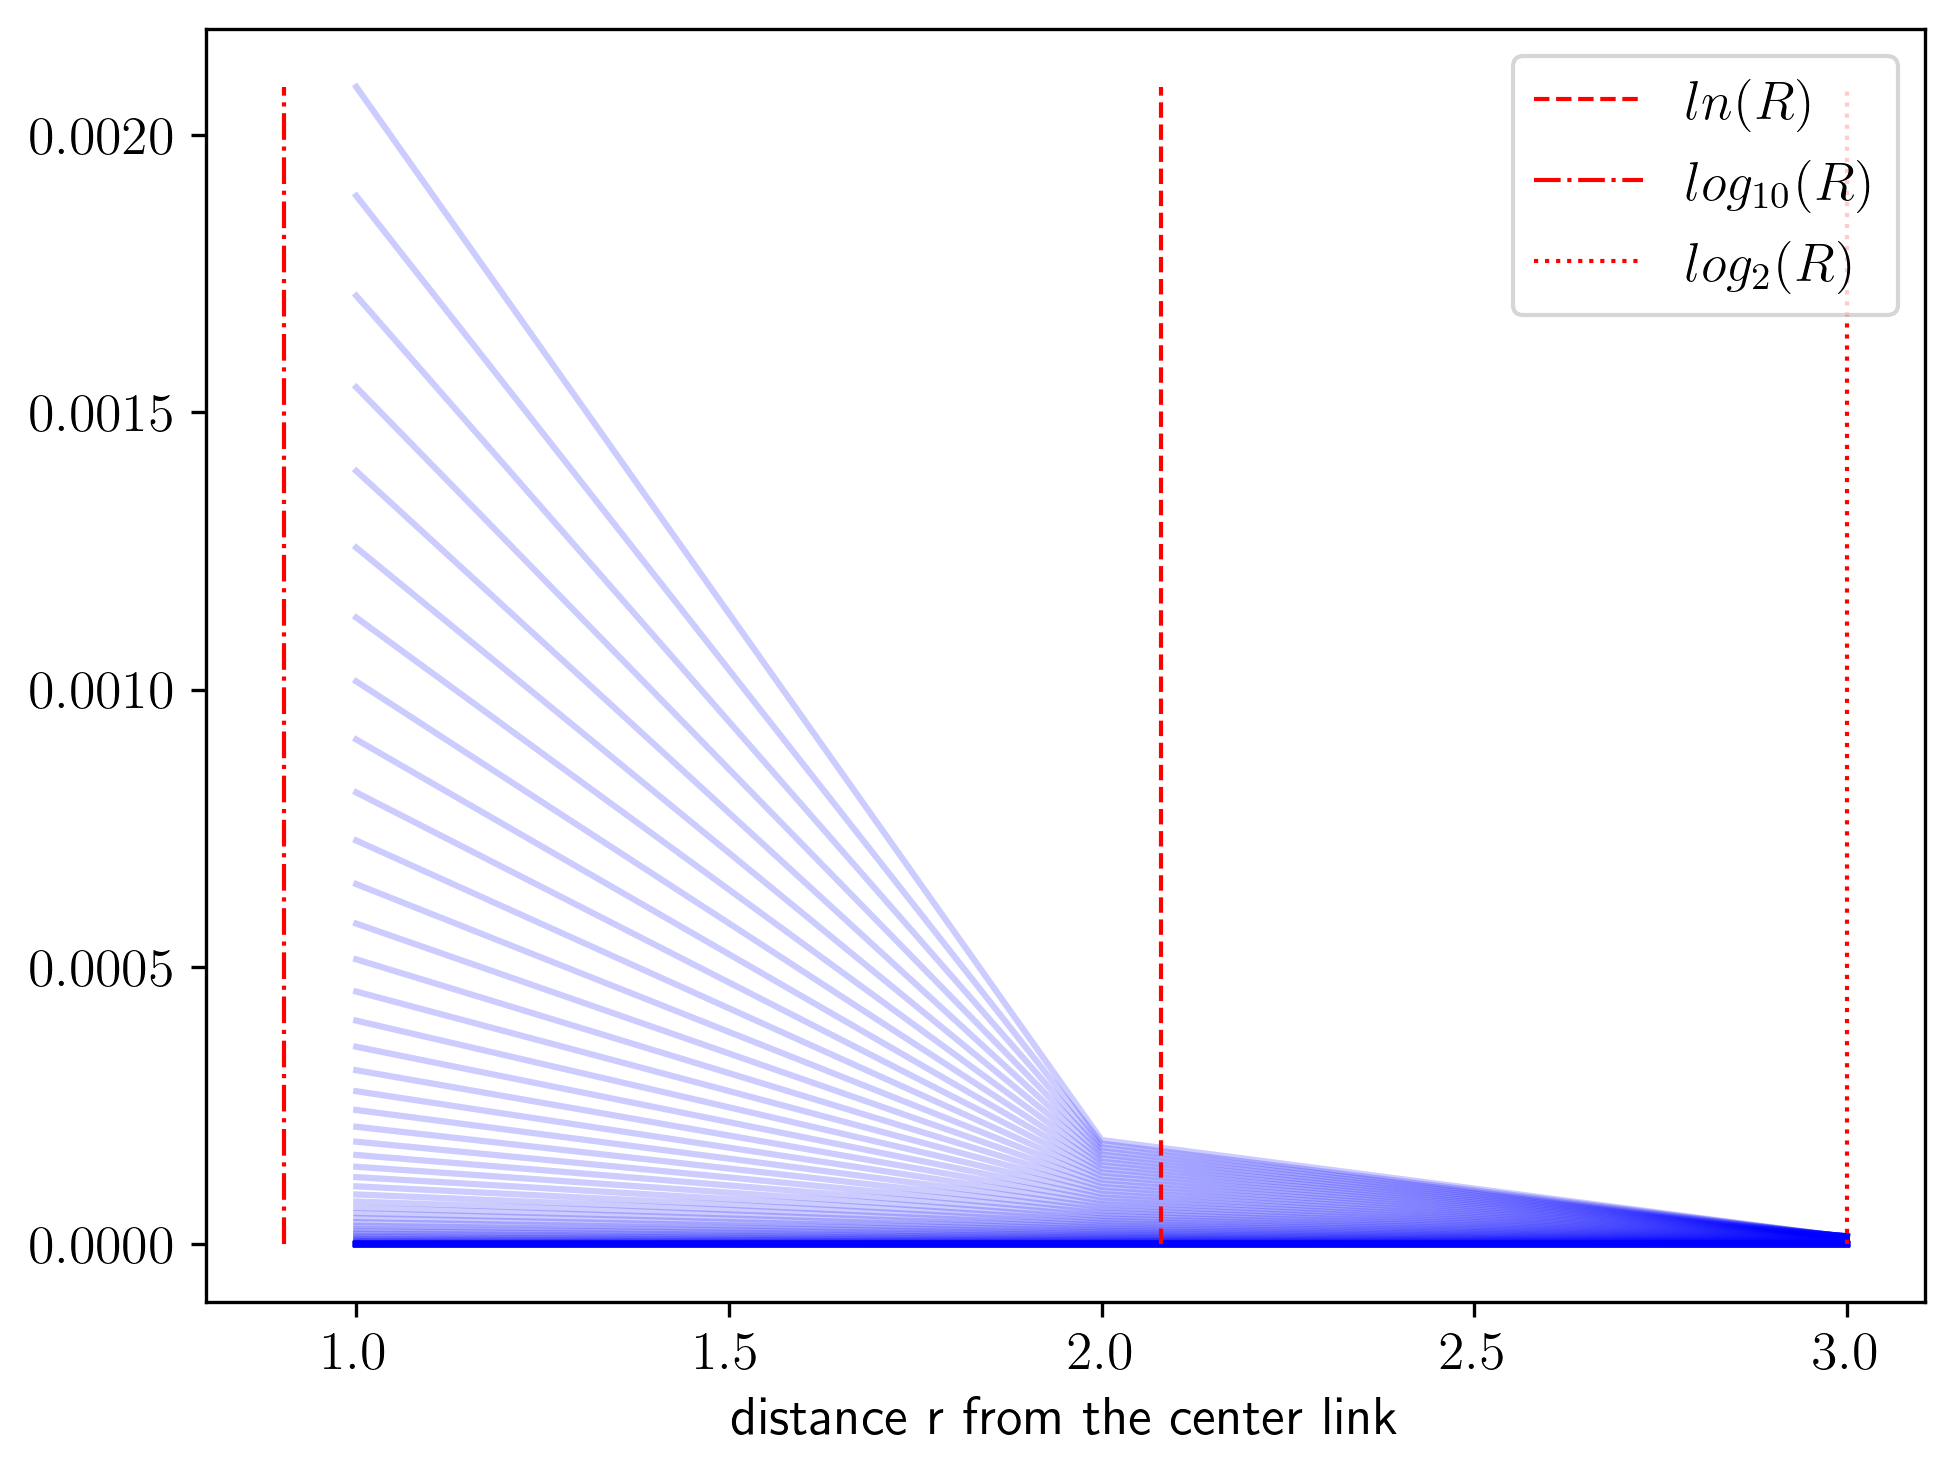

In [26]:
# energy density decay
for half_e in half_eed:
    plt.plot(range(1,l//2+1), half_e[::-1], alpha=0.2, color='blue')
plt.vlines(x=np.log(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.vlines(x=np.log10(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.vlines(x=np.log2(L_string), ymin=np.min(half_eed), ymax=np.max(half_eed), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.legend()
# plt.yscale('log')
plt.xlabel('distance r from the center link')
plt.show()

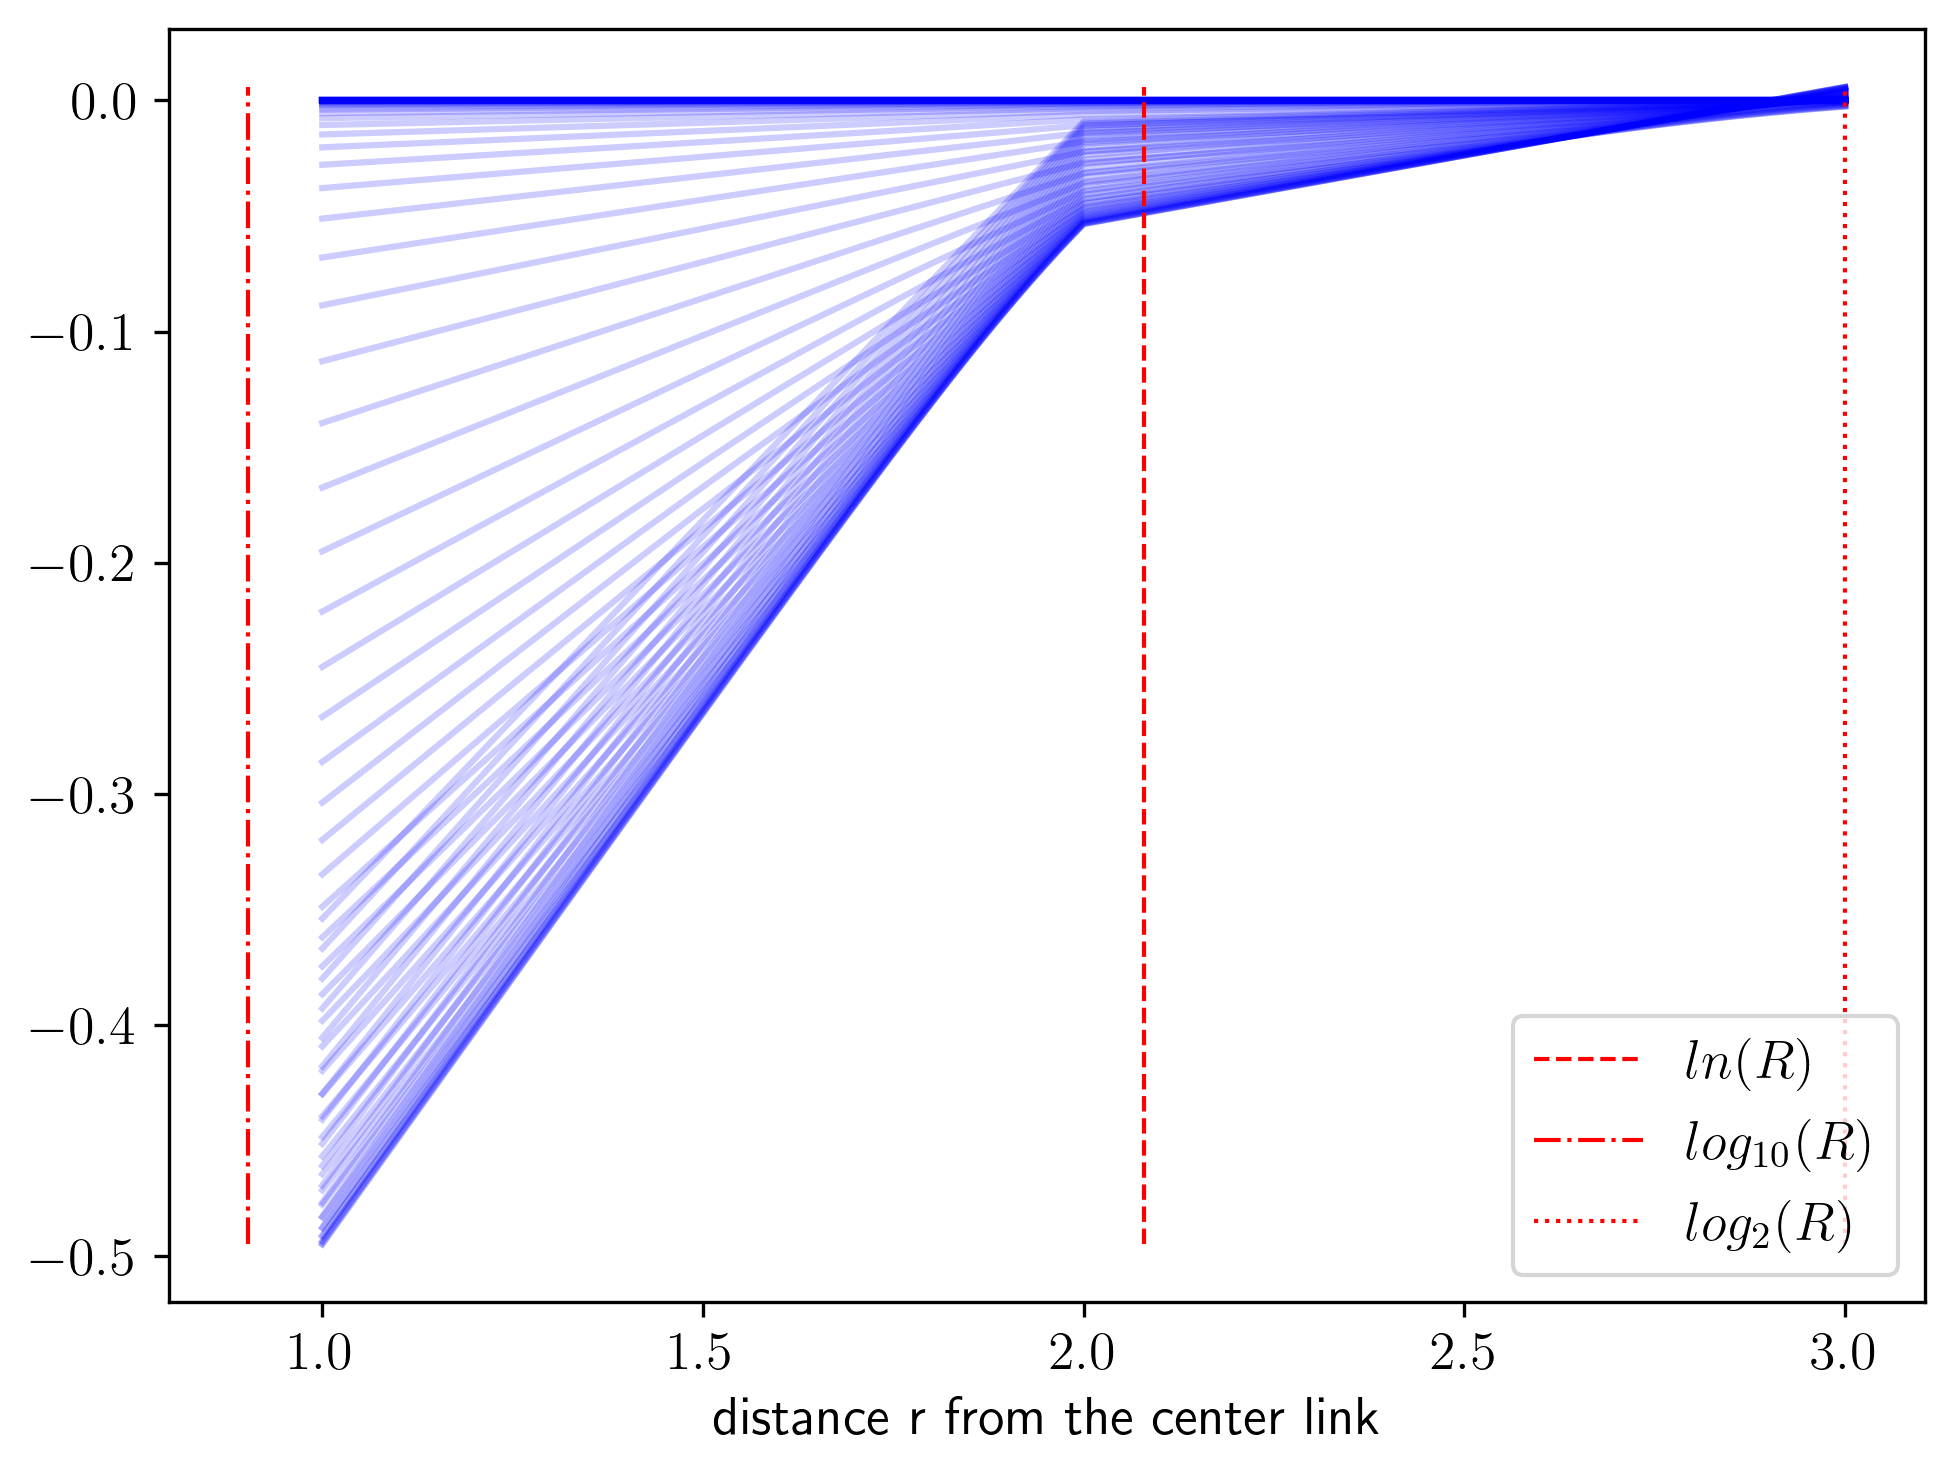

In [25]:
# correlator decay
for half_c in half_corr:
    plt.plot(range(1,l//2+1), half_c[::-1], alpha=0.2, color='blue')
plt.vlines(x=np.log(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle='--', linewidth=1, color='r', label='$ln(R)$')
plt.vlines(x=np.log10(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle='-.', linewidth=1, color='r', label='$log_{10}(R)$')
plt.vlines(x=np.log2(L_string), ymin=np.min(half_corr), ymax=np.max(half_corr), linestyle=':', linewidth=1, color='r', label='$log_{2}(R)$')
plt.legend()
# plt.yscale('log')
plt.xlabel('distance r from the center link')
plt.show()

In [45]:
np.linspace(0.5,1.5,201)

array([0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535, 0.54 ,
       0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 , 0.585,
       0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 ,
       0.635, 0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675,
       0.68 , 0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 ,
       0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765,
       0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 ,
       0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855,
       0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  ,
       0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945,
       0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 ,
       0.995, 1.   , 1.005, 1.01 , 1.015, 1.02 , 1.025, 1.03 , 1.035,
       1.04 , 1.045, 1.05 , 1.055, 1.06 , 1.065, 1.07 , 1.075, 1.08 ,
       1.085, 1.09 , 1.095, 1.1  , 1.105, 1.11 , 1.115, 1.12 , 1.125,
       1.13 , 1.135,

## Check the String Width $\sigma$ $vs$ the $log(R)$

In [4]:
L, l, hx_i, hx_f, npoints, chi = 20, 6, 0.5, 1.5, 50, 16
cxs = [[2,18],[3,17],[4,16],[5,15],[6,14]]
# cxs = [[1,19],[2,18],[3,17],[4,16],[5,15],[6,14],[7,13],[8,12],[9,11]]

# L, l, hx_i, hx_f, npoints, chi = 41, 6, 0.5, 1.5, 50, 64
# cxs = [[3,37],[4,36],[5,35],[6,34],[7,33],[8,32],[9,31],[10,30]]
cxs.reverse()

lin, log, retrieve = True, False, False
if log:
    interval = np.logspace(hx_i, hx_f, npoints)
    precision = int(np.max((np.abs(hx_i),np.abs(hx_f))))
elif lin:
    interval = np.linspace(hx_i, hx_f, npoints)
    num = (hx_f - hx_i) / npoints
    precision = get_precision(num)

In [ ]:
eed_conn_strings = []
for cx in cxs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges()
        eed_vacuum = compute_electric_energy_density_vacuum()
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_strings.append(eed_conn_r)

In [ ]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_strings = []
for eed_conn in eed_conn_strings:   
    eed_string = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_string.append(eed_sum_lad)
    eed_strings.append(eed_string)

In [ ]:
h_i = 0.5
h_f = 0.7
npoints = 101
interval = np.linspace(h_i,h_f,npoints)
Rs = [int(cx[1]-cx[0]) for cx in cxs]
colors = create_sequential_colors(npoints, colormap_name='seismic')
for g in interval:
    sigma_g = eed_strings[:, g]
    plt.plot(np.log(Rs), sigma_g)
plt.show()

In [12]:
L, l, chi, h_i, h_f, npoints = 4, 4, 16, 0.1, 1.0, 10
cx = [0,4]
cxs = [[0,4],[1,3]]
cy = [2,2]

L, l, h_i, h_f, npoints, chi = 20, 6, 0.5, 1.5, 50, 16
cxs = [[2,18],[3,17],[4,16],[5,15],[6,14]]
# cxs = [[1,19],[2,18],[3,17],[4,16],[5,15],[6,14],[7,13],[8,12],[9,11]]

L, l, h_i, h_f, npoints, chi = 30, 6, 0.8, 1.0, 30, 128
cxs = [[3,27],[4,26],[5,25],[6,24],[7,23],[8,22],[9,21]]
# cxs = [[9,21]]

# L, l, hx_i, hx_f, npoints, chi = 41, 6, 0.5, 1.5, 50, 64
# cxs = [[3,37],[4,36],[5,35],[6,34],[7,33],[8,32],[9,31],[10,30]]
cy = [3,3]

cxs.reverse()
Rs = [np.abs(cx[0]-cx[1]) for cx in cxs]
interval = np.linspace(h_i, h_f, npoints)
precision = get_precision((h_f-h_i)/npoints)

In [13]:
def compute_electric_energy_density_vacuum(energy_contribution: str, cc: str="h"):
    eed_vacuum = []
    for h in interval:
        print(f"Energy Density - vacuum for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.load_sites(path=path_tensor, precision=precision)
        if energy_contribution == "t":
            eed = lattice_mps.mpo_Z2_column_total_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "e":
            eed = lattice_mps.mpo_Z2_column_electric_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "m":
            eed = lattice_mps.mpo_Z2_column_magnetic_energy_density(site=L//2, cc=cc)
        eed_vacuum.append(eed)
    return eed_vacuum

def compute_electric_energy_density_charges(energy_contribution: str, cx: list, cy: list, cc: str="h"):
    eed_charges = []
    for h in interval:
        print(f"Energy Density - charges for h: {h}")
        lattice_mps = MPS(L=L,d=2**l, model="Z2_dual", chi=chi, h=h)
        lattice_mps.load_sites(path=path_tensor, precision=precision, cx=cx, cy=cy)
        lattice_mps.Z2.add_charges(rows=cx, columns=cy)
        if energy_contribution == "t":
            eed = lattice_mps.mpo_Z2_column_total_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "e":
            eed = lattice_mps.mpo_Z2_column_electric_energy_density(site=L//2, cc=cc)
        elif energy_contribution == "m":
            eed = lattice_mps.mpo_Z2_column_magnetic_energy_density(site=L//2, cc=cc)
        eed_charges.append(eed)
    return eed_charges

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_963/2836201981.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("string width $(\sigma)$", fontsize=20)


Energy Density - vacuum for h: 0.8
Energy Density - vacuum for h: 0.806896551724138
Energy Density - vacuum for h: 0.8137931034482759
Energy Density - vacuum for h: 0.8206896551724139
Energy Density - vacuum for h: 0.8275862068965517
Energy Density - vacuum for h: 0.8344827586206897
Energy Density - vacuum for h: 0.8413793103448276
Energy Density - vacuum for h: 0.8482758620689655
Energy Density - vacuum for h: 0.8551724137931035
Energy Density - vacuum for h: 0.8620689655172414
Energy Density - vacuum for h: 0.8689655172413794
Energy Density - vacuum for h: 0.8758620689655172
Energy Density - vacuum for h: 0.8827586206896552
Energy Density - vacuum for h: 0.8896551724137931
Energy Density - vacuum for h: 0.896551724137931
Energy Density - vacuum for h: 0.903448275862069
Energy Density - vacuum for h: 0.9103448275862069
Energy Density - vacuum for h: 0.9172413793103449
Energy Density - vacuum for h: 0.9241379310344828
Energy Density - vacuum for h: 0.9310344827586207
Energy Density - v

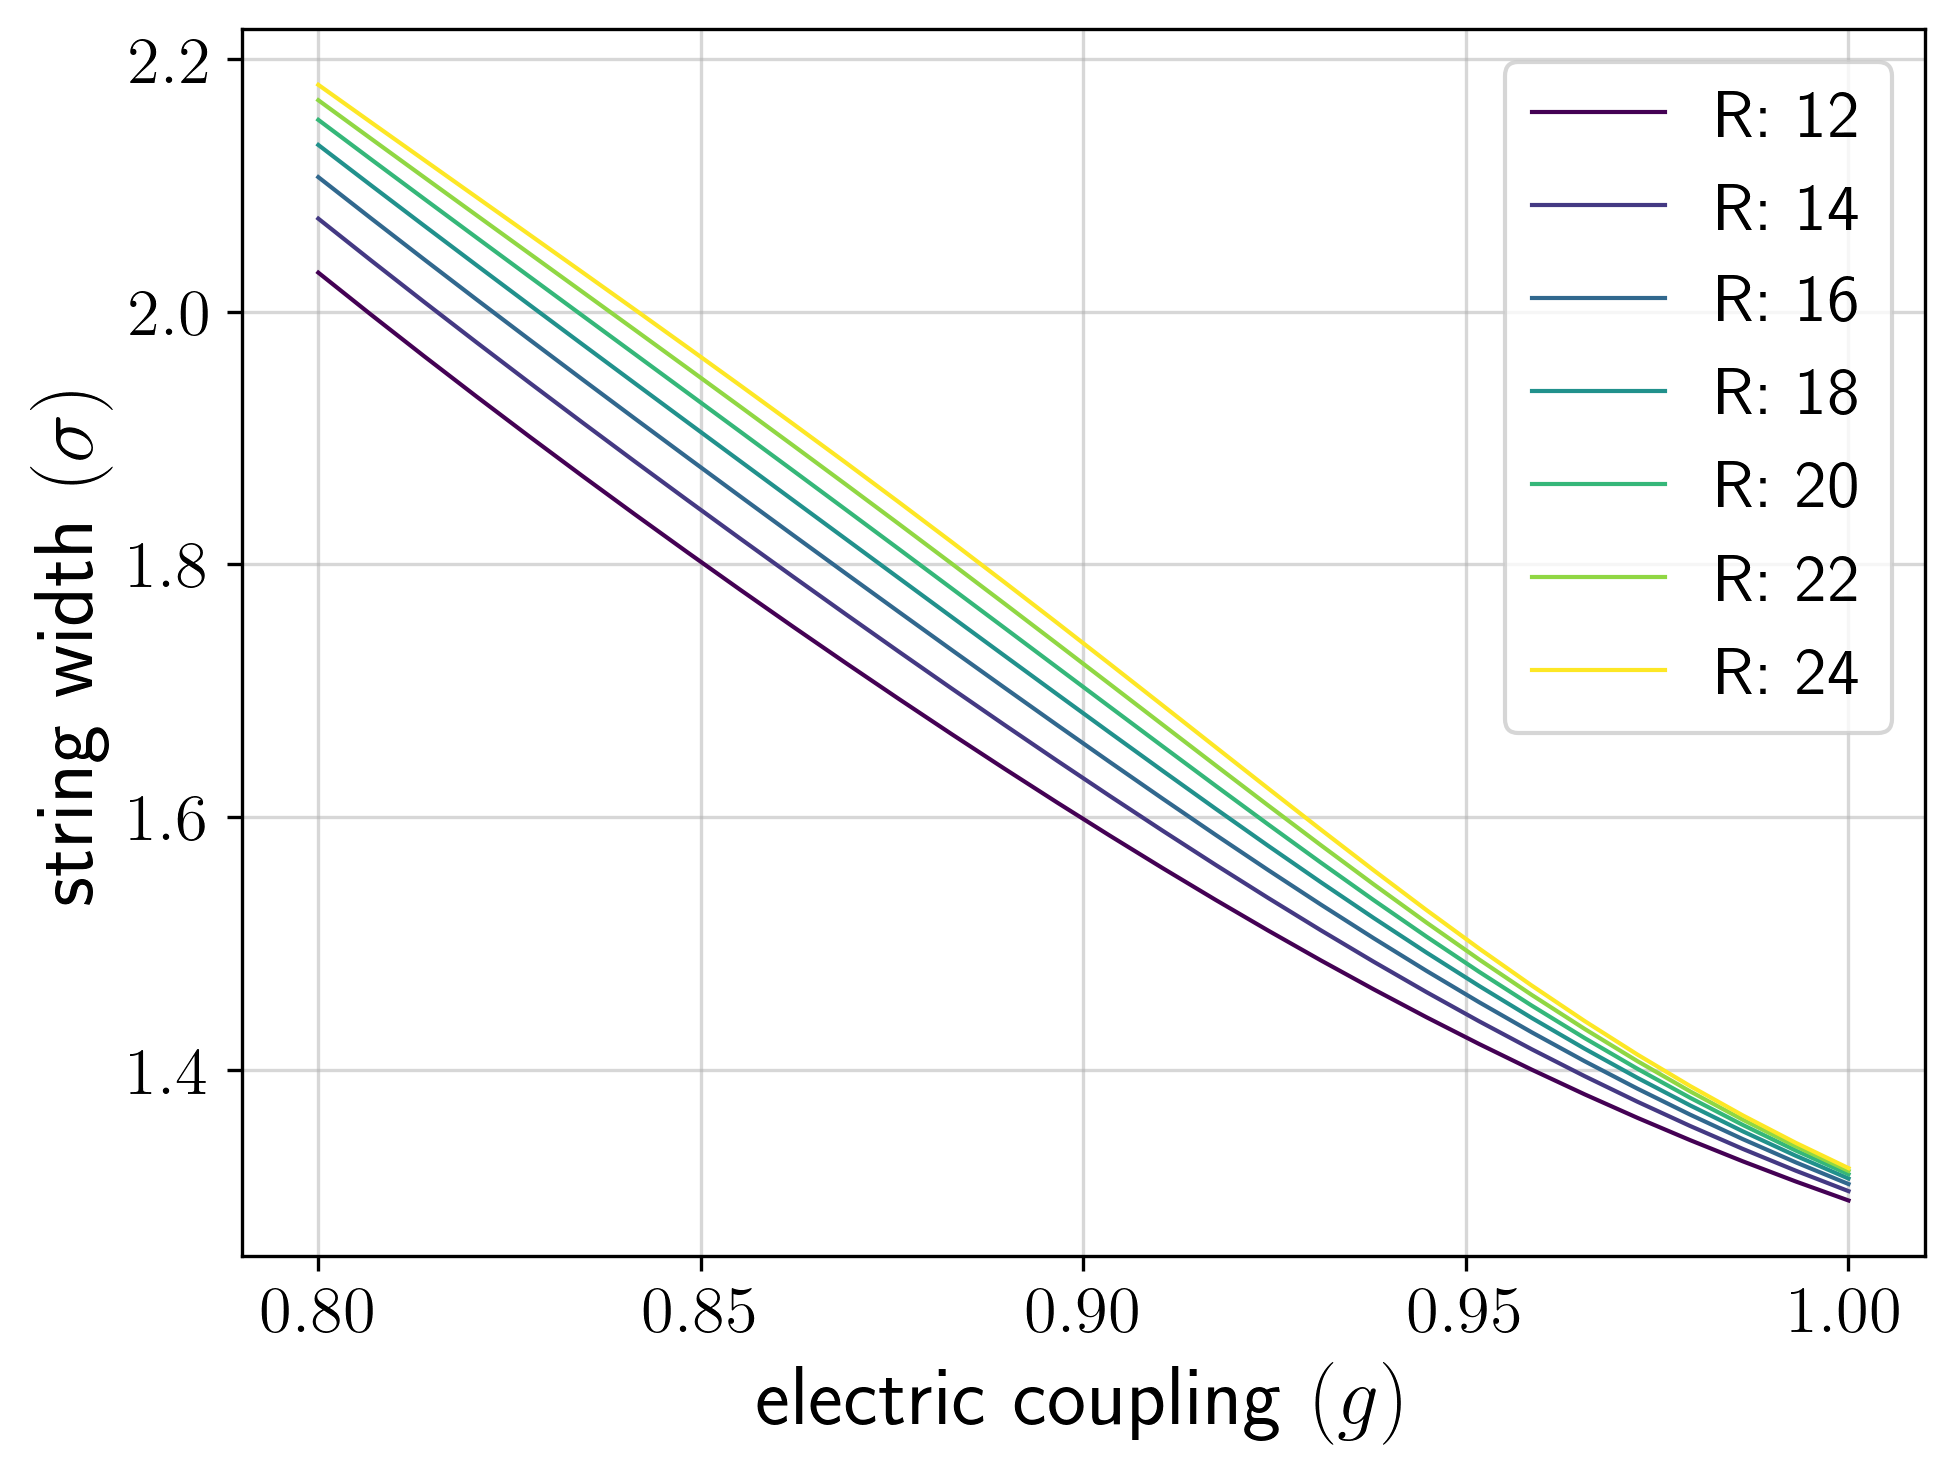

In [15]:
energy_contribution = "e"
eed_conn_strings = []
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc="h")
for cx in cxs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc="h")
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_strings.append(eed_conn_r)

# we find the string width as a normalized sum of the electric energy density for the position squared
eed_strings = []
colors = create_sequential_colors(len(Rs))
for k, eed_conn in enumerate(eed_conn_strings):
    eed_string = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_string.append(eed_sum_lad)
    plt.plot(interval, eed_string, color=colors[k], linewidth=1, label=f"R: {Rs[k]}")
    eed_strings.append(eed_string)
plt.xlabel("electric coupling $(g)$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)
plt.savefig(f"{parent_path}/figures/fluxtube/string_width_different_Rs_{int(cxs[-1][1]-cxs[-1][0])}-{int(cxs[0][1]-cxs[0][0])}_{model}_direct_lattice_{l}x{L}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")

### $log(R)$ behaviour for $g_r$

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_963/2567937557.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("string width $(\sigma)$", fontsize=20)


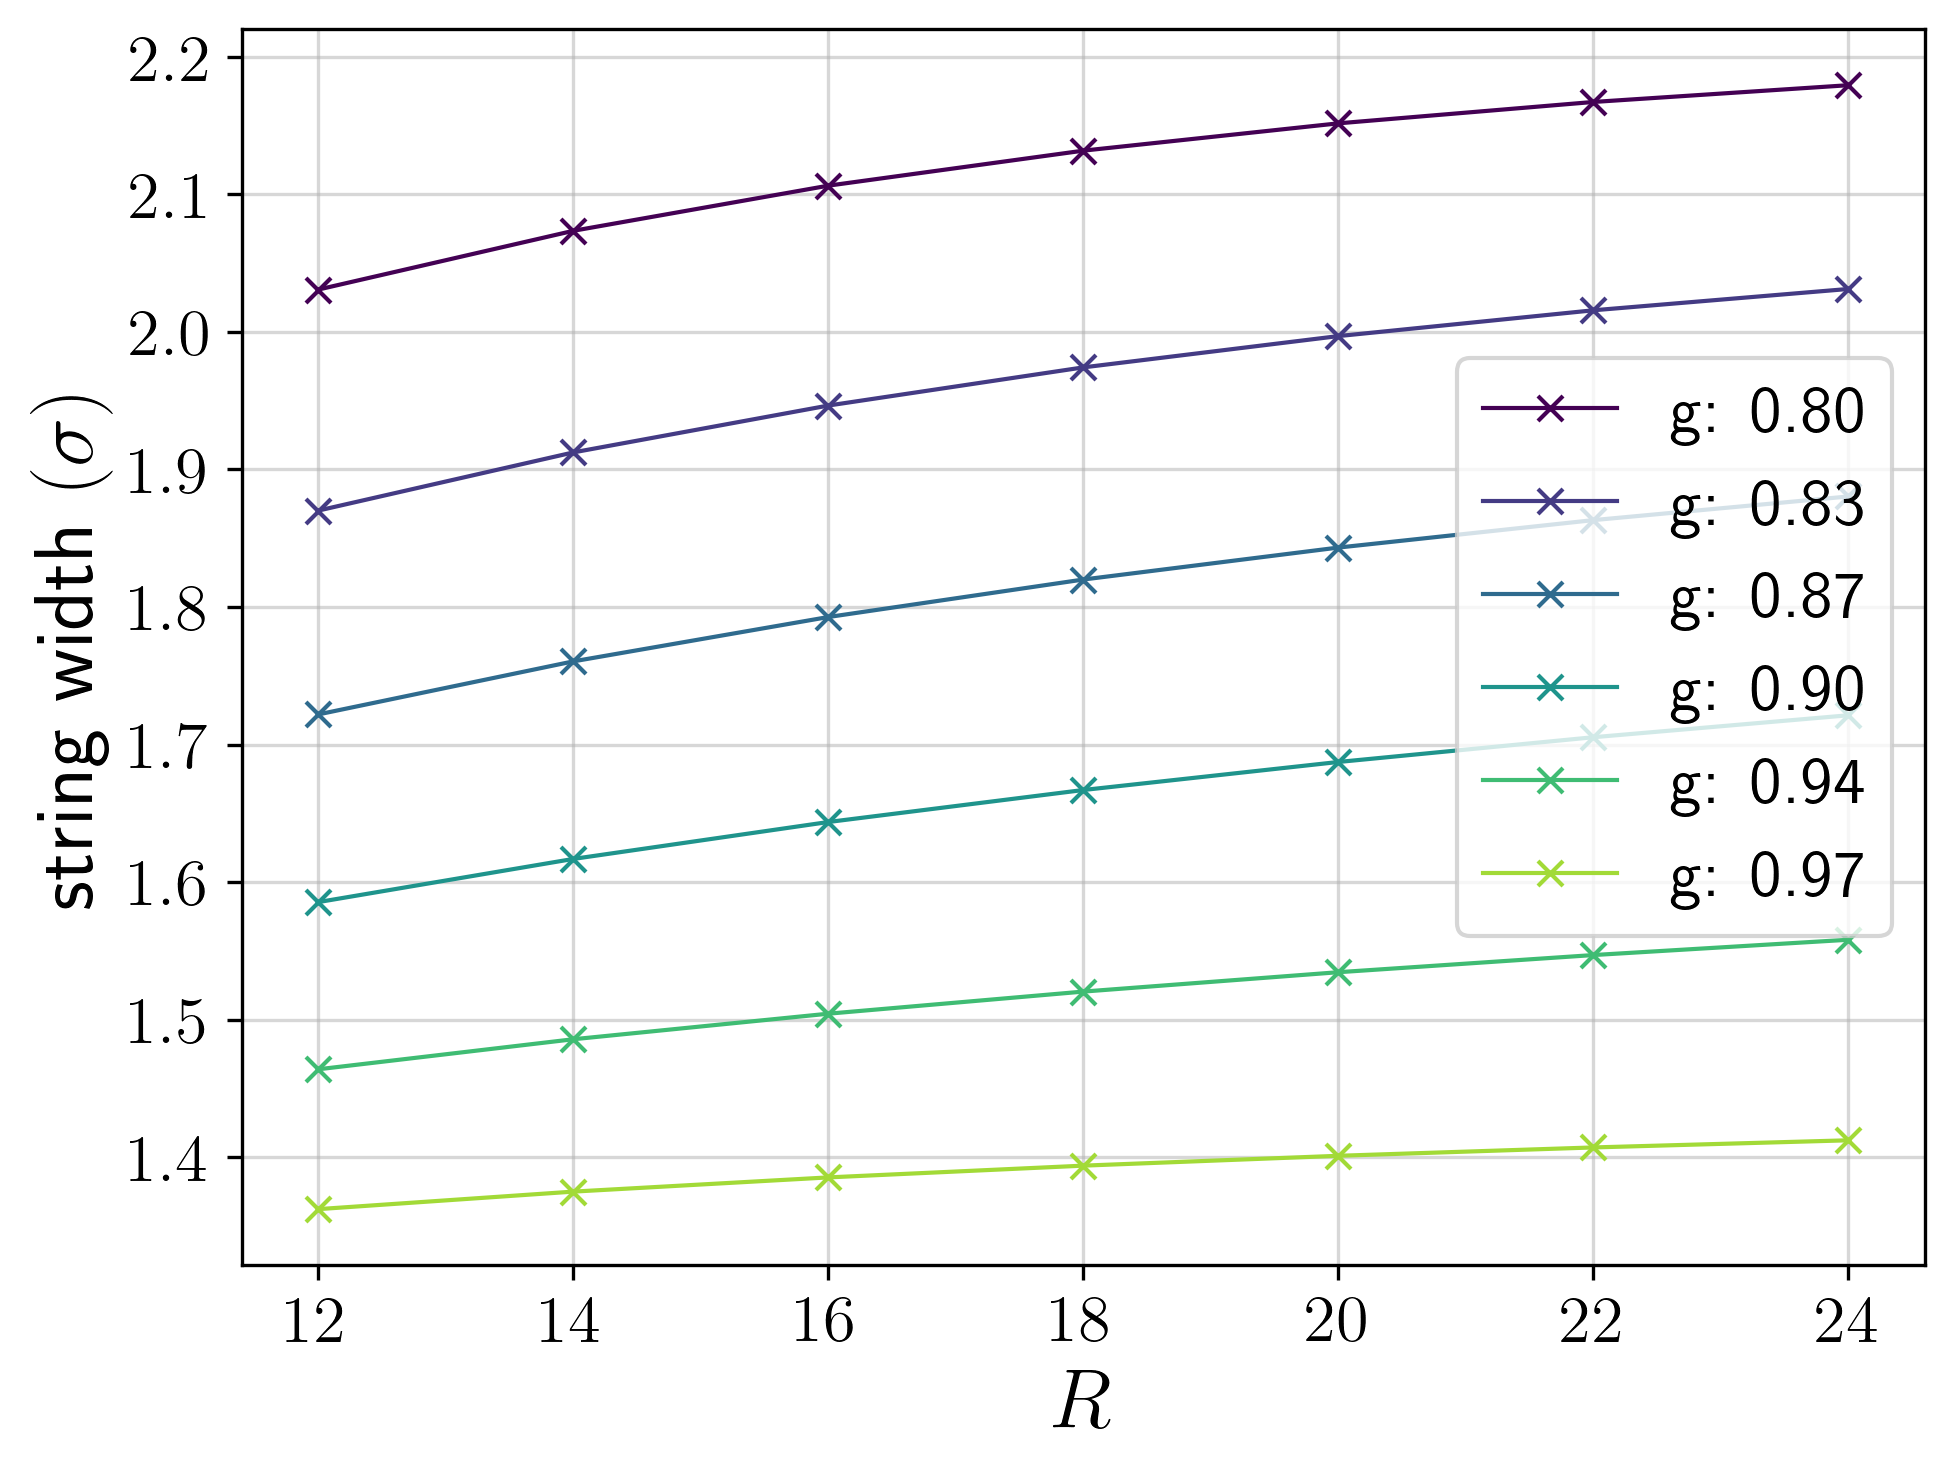

In [30]:
eed_gs = [np.asarray(eed_strings)[:,i] for i, g in enumerate(interval)][::5]
colors = create_sequential_colors(len(interval))
for k, eed_g in enumerate(eed_gs):
#     plt.plot(np.log(Rs), eed_g, 'x', color=colors[5*k], linestyle='-', linewidth=1, label=f"g: {interval[5*k]:.2f}")
    plt.plot(Rs, eed_g, 'x', color=colors[5*k], linestyle='-', linewidth=1, label=f"g: {interval[5*k]:.2f}")
# plt.xlabel("$log(R)$", fontsize=20)
plt.xlabel("$R$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)
plt.savefig(f"{parent_path}/figures/fluxtube/string_width_vs_R_{int(cxs[-1][1]-cxs[-1][0])}-{int(cxs[0][1]-cxs[0][0])}_{model}_direct_lattice_{l}x{L}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.png")   

### Energetic contributions to string thickness $\sigma$

In [ ]:
energy_contributions = ["t","e","m"]
eed_conn_ham_type = []
cx = cxs[0]
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc="v")
for energy_contribution in energy_contributions:
    print(f"computing for R: {np.abs(cxs[0][0]-cxs[0][1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc="v")
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_ham_type.append(eed_conn_r)

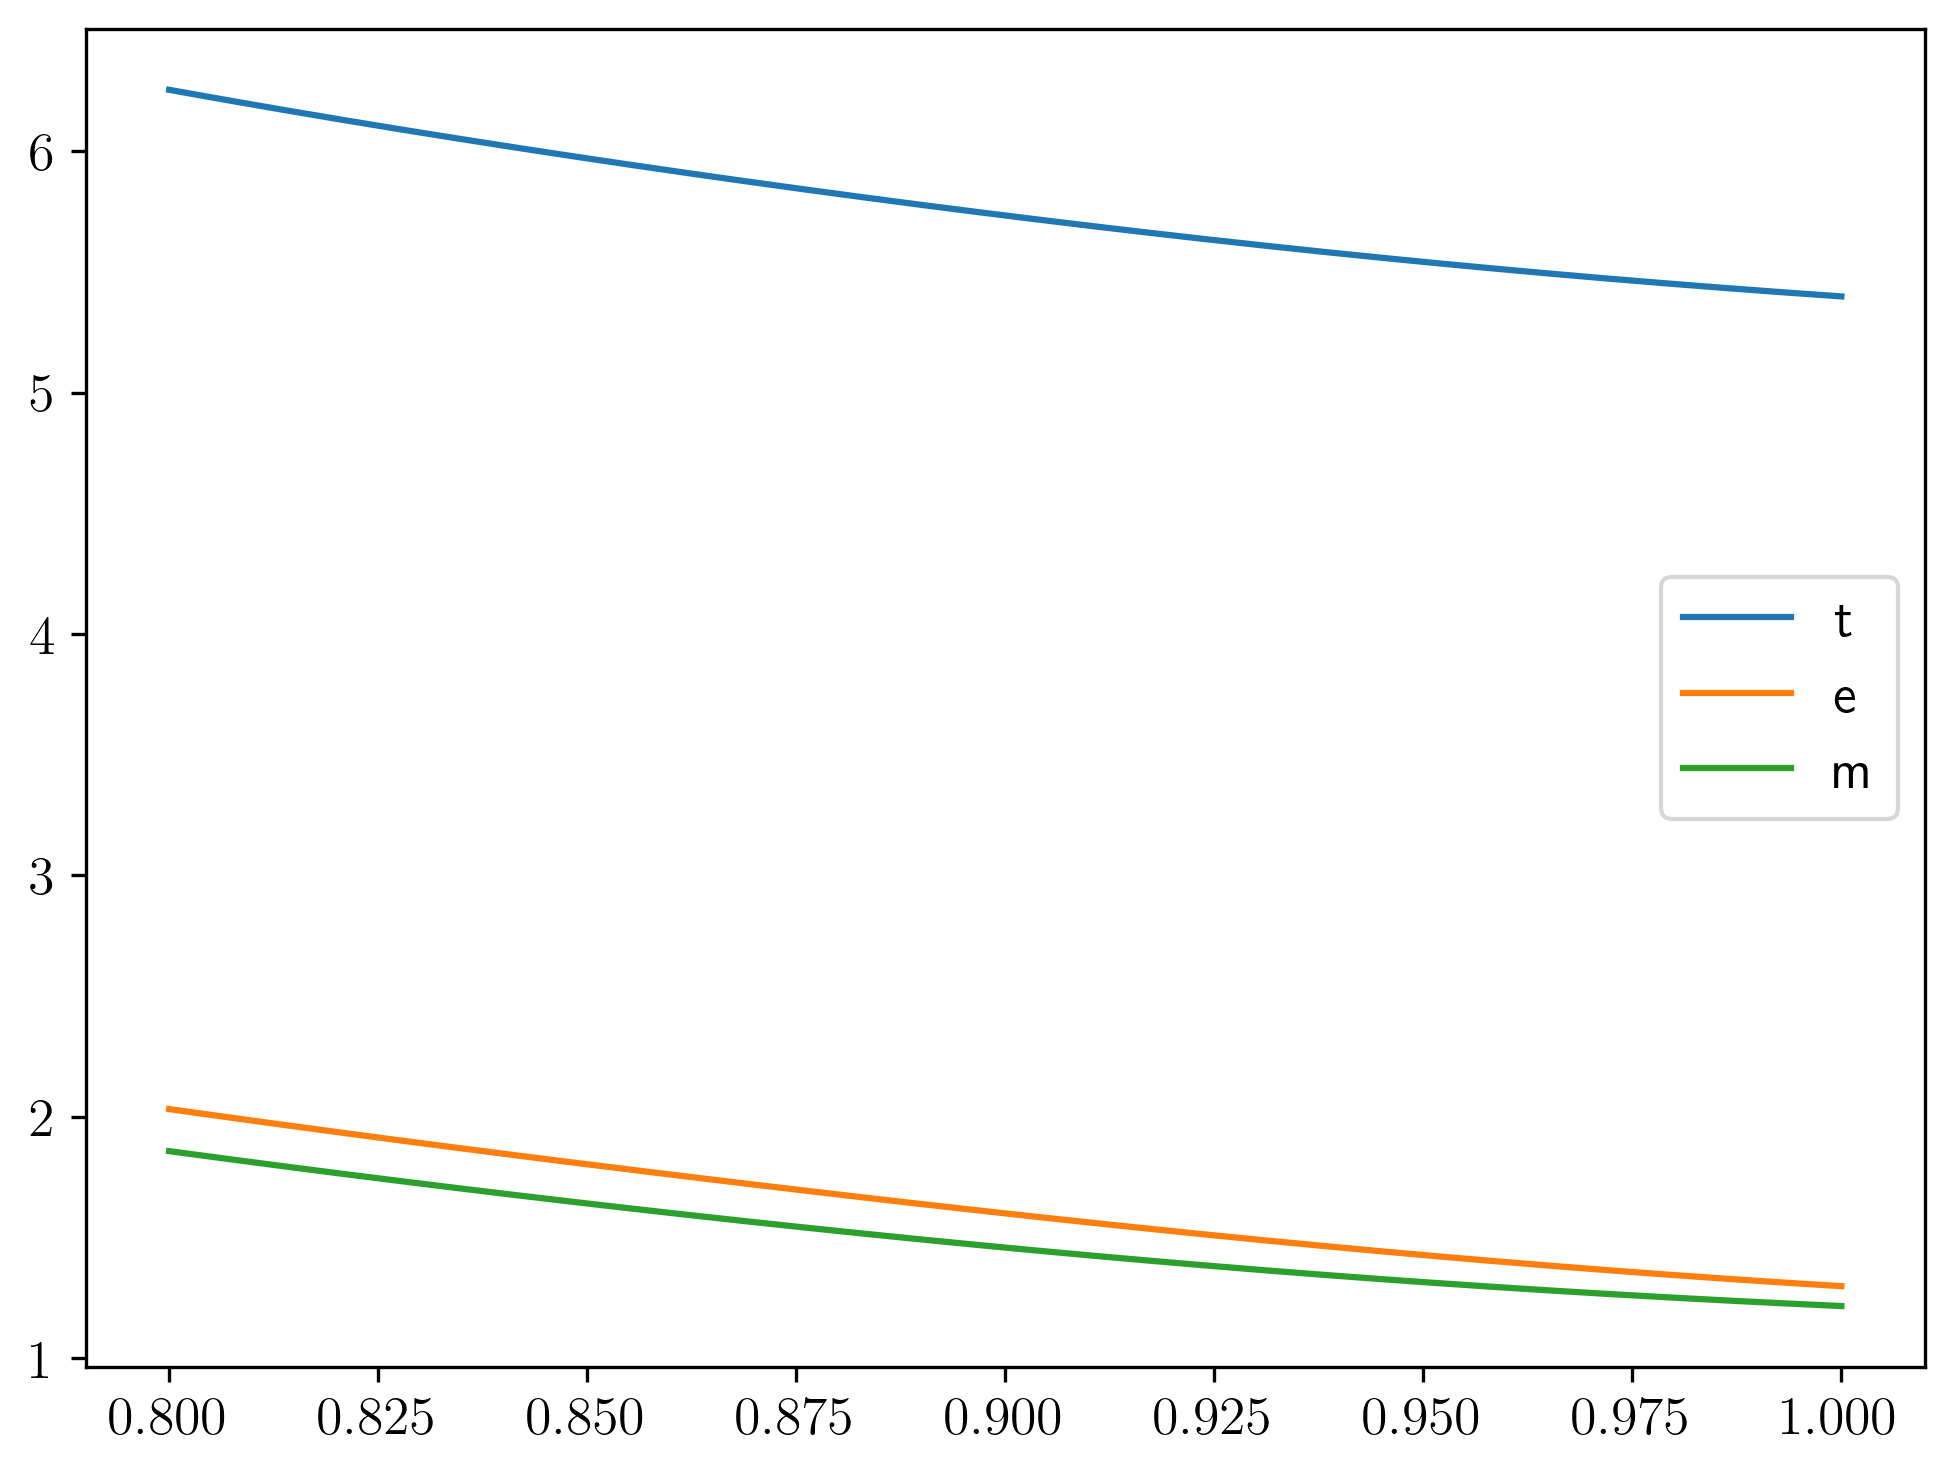

In [34]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_hams = []
for k, eed_conn in enumerate(eed_conn_ham_type):   
    eed_ham = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_ham.append(eed_sum_lad)
    plt.plot(interval, eed_ham, label=f"{energy_contributions[k]}")
    eed_hams.append(eed_ham)
plt.legend()

In [ ]:
energy_contribution = "e"
eed_conn_charges = []
ccs = ["h","v"]
eed_vacuum = compute_electric_energy_density_vacuum(energy_contribution=energy_contribution, cc=cc)
for cc in ccs:
    print(f"computing for R: {np.abs(cx[0]-cx[1])}")
    if endens:
        # compute the connected electric energy density
        eed_charges = compute_electric_energy_density_charges(energy_contribution=energy_contribution, cx=cx, cy=cy, cc=cc)
        eed_conn_r = (np.array(eed_charges) - np.array(eed_vacuum))
    eed_conn_charges.append(eed_conn_r)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_963/4000747562.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("string width $(\sigma)$", fontsize=20)
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_963/4000747562.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("string width $(\sigma)$", fontsize=20)


IndexError: list index out of range

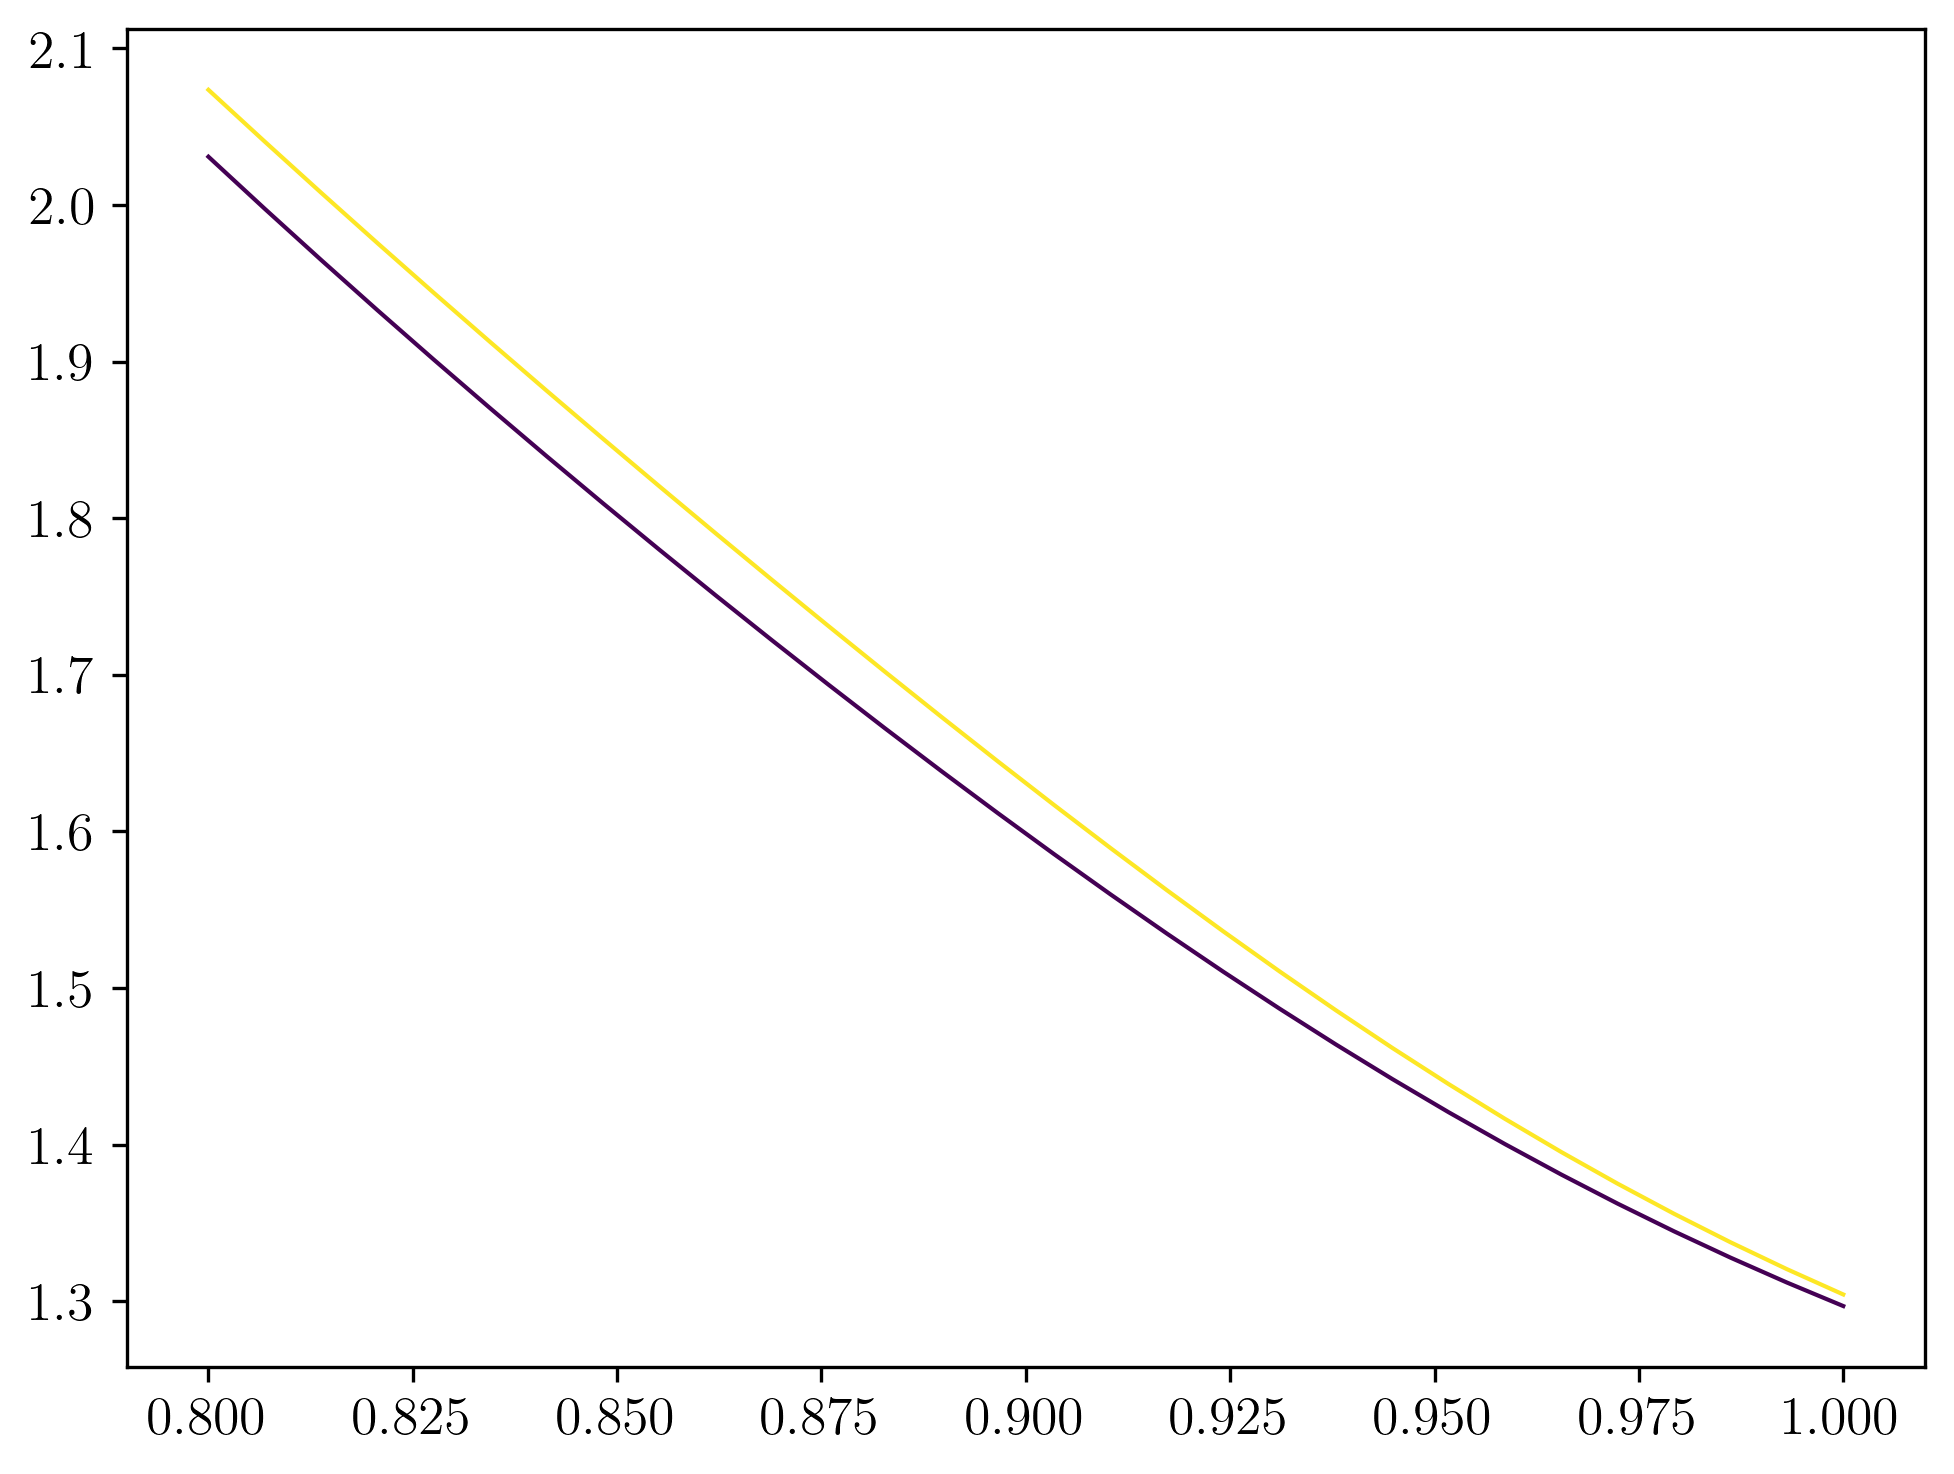

In [35]:
# we find the string width as a normalized sum of the electric energy density for the position squared
eed_charge_convs = []
colors = create_sequential_colors(len(ccs))
for k, eed_conn in enumerate(eed_conn_charges):
    eed_charge_conv = []
    xs = [i for i in range(-l//2,l//2+1,) if i!=0]
    for eed_lad in eed_conn:
        eed_sum_lad = 0
        for x, eed_x in zip(xs, eed_lad):
            eed_sum_lad += eed_x * ((x)**2)
        eed_sum_lad = eed_sum_lad / sum(eed_lad)
        eed_charge_conv.append(eed_sum_lad)
    plt.plot(interval, eed_charge_conv, color=colors[k], linewidth=1, label=f"cc: {ccs[k]}")
    eed_charge_convs.append(eed_charge_conv)
plt.xlabel("electric coupling $(g)$", fontsize=20)
plt.ylabel("string width $(\sigma)$", fontsize=20)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.5)

## Hamiltonian formulation of the effective string

In [3]:
def hamiltonian_effective_string_width(sigma,R):
    return 1 / (np.pi * sigma) * np.sum([1 / (k + 1/2) for k in range(R)])

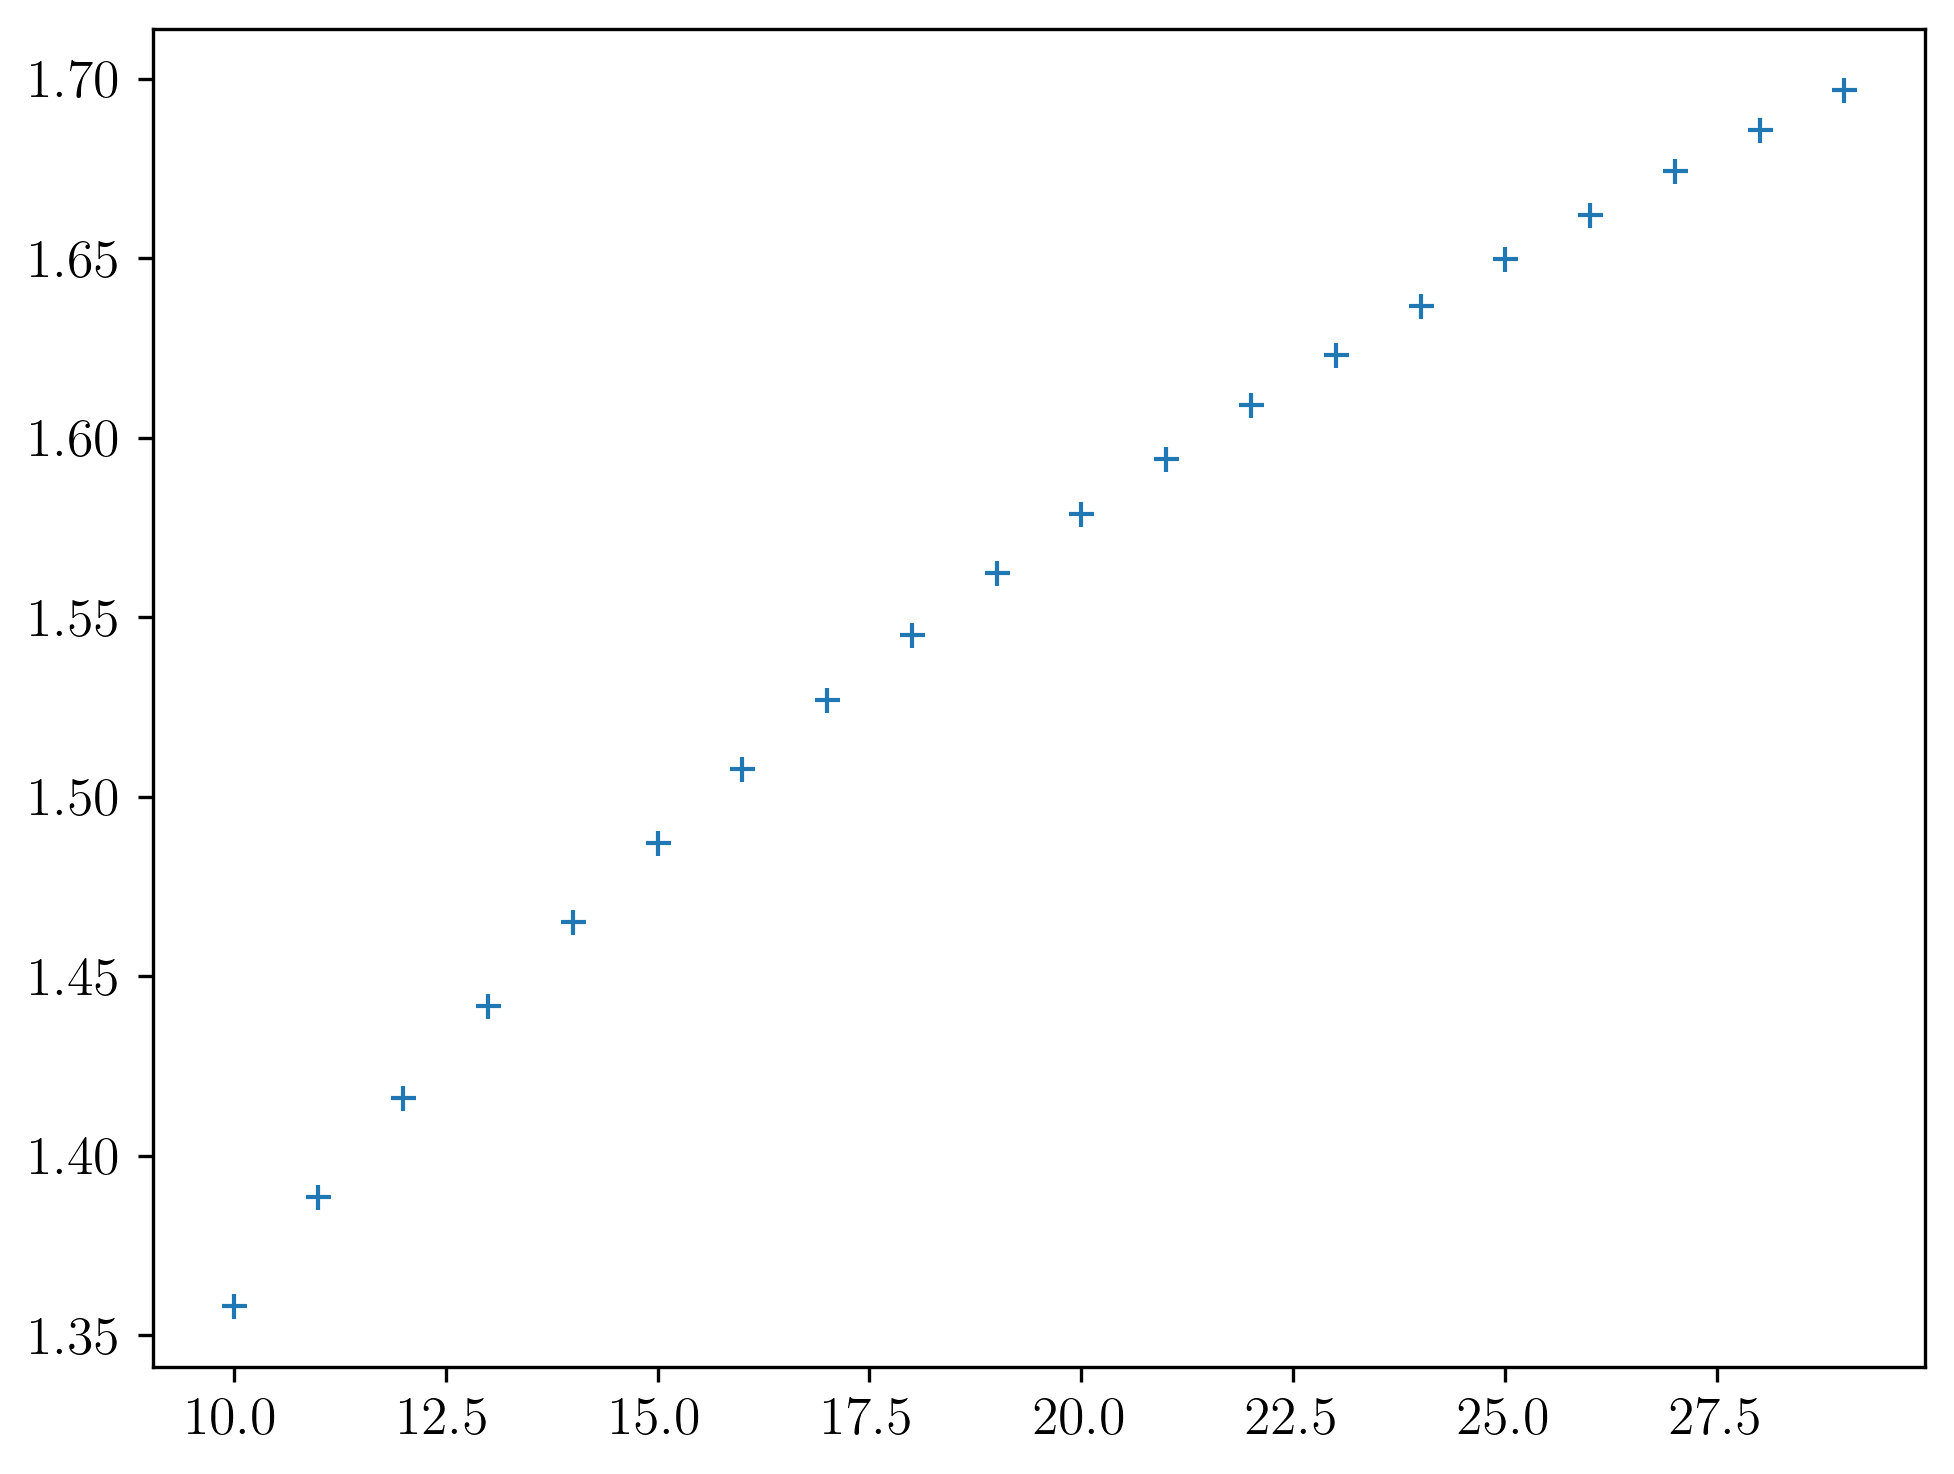

In [6]:
sigma = 1
Rs = range(10,30)
width = []
for R in Rs:
    width.append(hamiltonian_effective_string_width(sigma,R))


plt.plot(Rs, width, '+')

# String Width $w$ as Connect ed Energy Density $\mathcal{E}(x)$

We find the string width as follows

$$w^2 = \frac{\sum_x x^2 \mathcal{E}(x)}{\sum_x \mathcal{E}(x)}$$

In [ ]:
# free param
chis = [16,32,64]
# Ls = [40,50]
# Rs = [20,22,24,26,28]
Ls = [30]
Rs = [18,20,22,24]
R = 18
# secondary fixed params
bc = "pbc"
# npoints, h_i, h_f = 30, 0.8, 1.0
npoints, h_i, h_f = 61, 0.4, 1.0
interval = np.linspace(h_i,h_f,npoints)
gs = interval

# fixed params
l = 4

In [47]:
w = string_width_chis(g,R,l,L,chis,bc,sector,h_i,h_f,npoints,path_tensor)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/fradm/Desktop/projects/1_Z2/results/energy_data/electric_energy_density_Z2_dual_direct_lattice_3x30_2_particle(s)_sector_bc_pbc_[6, 24]-[0, 0]_h_0.4-1.0_delta_61_chi_16.npy'